# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Define some functions for later '''
def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

def tuning_curve_bytrial(x, trial, Y, dt, b, sigma, smooth=True, normalize=False, occupancy=True):
    '''
    Params
    ------
    x : ndarray
        variable of interest by observation; shape (n_obs, )
    trial : ndarray
        trial num for each observation; shape (n_obs, )
    Y : ndarray
        spikes per observation; shape (n_obs, n_cells)
    dt : int
        time per observation in seconds
    b : int
        bin size
    sigma : int
        SD of Gaussian filter
    smooth : bool
        apply gaussian filter to firing rate; optional, default is True
    normalize : bool
        normalize the firing rate of each cell such that its max FR is 1, min is 0;
        optional, default is False
    occupancy : bool
        return occupancy (dwell time in each bin); optional, default is True

    Returns
    -------
    firing_rate : ndarray
        binned firing rate for each trial for each cell; shape (n_trials, n_bins, n_cells)
    centers : ndarray
        center of each bin
    occ : ndarray
       dwell time in each bin; shape (n_bins, n_cells)
    '''
    edges = np.arange(0, np.max(x) + b, b)
    centers = (edges[:-1] + edges[1:])/2
    b_idx = np.digitize(x, edges)
    if np.max(x) == edges[-1]:
        b_idx[b_idx==np.max(b_idx)] = np.max(b_idx) - 1
    unique_bdx = np.unique(b_idx)

    # find FR in each bin
    firing_rate = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    occ = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    for j in range(unique_bdx.shape[0]):
        idx1 = (b_idx == unique_bdx[j])
        for i, t in enumerate(np.unique(trial)):
            idx = idx1 & (trial == t)
            if np.sum(idx)==0:
                #print('warning: zero occupancy!')
                firing_rate[i, j, :] = firing_rate[i, j-1, :]
                occ[i, j, :] = 0
            else:    
                spike_ct = np.sum(Y[idx, :], axis=0)
                occupancy = dt * np.sum(idx)
                occ[i, j, :] = occupancy
                firing_rate[i, j, :] = spike_ct / occupancy
    if smooth:
        firing_rate = gaussian_filter1d(firing_rate, sigma, axis=1, mode='wrap')

    if normalize:
        for c in range(firing_rate.shape[2]):
            firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))
    
    if occupancy:
        return firing_rate, centers, occ
    else: 
        return firing_rate, centers
    
def find8adjacentElements(test_list):
    ''' 
    Params
    ------
    test_list : ndarray
        1d array to be sorted
    
    Returns
    -------
    neighbors : list
        nested list where each element is a list of 8 adjacent elements to the element with the same 
        index in test_list, adjusting for the first and last four elements and not including 
    '''
    
    neighbors = []
    for idx, ele in enumerate(test_list):
    # Checking for all cases to append
        if idx == 0:
            neighbors.append(test_list[(idx+1):(idx + 9)])
        elif idx == 1:
            neighbors.append(np.concatenate((test_list[(idx - 1)],test_list[(idx+1):(idx + 8)]),axis=None))
        elif idx == 2:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 7)]),axis=None))
        elif idx == 3:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 6)]),axis=None))
        elif idx == len(test_list) - 1:
            neighbors.append(np.concatenate((test_list[(idx-8):idx]),axis=None))                     
        elif idx == len(test_list) - 2:
            neighbors.append(np.concatenate((test_list[(idx-7):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 3:
            neighbors.append(np.concatenate((test_list[(idx-6):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 4:
            neighbors.append(np.concatenate((test_list[(idx-5):idx],test_list[(idx + 1):]),axis = None))
        else:
            neighbors.append(np.concatenate((test_list[(idx - 4):idx],test_list[(idx+1):(idx + 5)]),axis=None))
    return neighbors 

def find(x):
    return x.nonzero()[0]

def autocorr(x,lags):
    '''numpy.correlate'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

In [5]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [6]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [14]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsitya/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherencea/' # adjust to match location of this Dryad repo folder
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/' # adjust to match location of this Dryad repo folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder
engagement_folder = 'C:/Users/Python/Desktop/LocalData/Figure1S1S2/' # adjust to match Figure 1, S1, S2 output save_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure2S3/' 

In [7]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [8]:
''' Get reward & lick data for sessions w/ neural data'''

load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #adjust to output of Import/Filter notebook

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
         # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            

Skipped & dark trials omitted from reward data, n skipped = 3
Mouse A14 with n_misses: 183
got lick indices for mouse A14 session 083022_record1
got reward indices for mouse A14 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 11
Mouse A14 with n_misses: 154
got lick indices for mouse A14 session 083122_record2
got reward indices for mouse A14 session 083122_record2
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A14 with n_misses: 145
got lick indices for mouse A14 session 090122_record3
got reward indices for mouse A14 session 090122_record3
No trials skipped; only dark trials omitted from reward data
Mouse A15 with n_misses: 105
got lick indices for mouse A15 session 083022_record1
got reward indices for mouse A15 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A15 with n_misses: 80
got lick indices for mouse A15 session 083122_record2
got reward indices for mouse A15 session 083122_reco

No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 104
got lick indices for mouse A22 session 020223_record6
got reward indices for mouse A22 session 020223_record6
No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 84
got lick indices for mouse A22 session 020323_record7
got reward indices for mouse A22 session 020323_record7
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 141
got lick indices for mouse A23 session 020923_record1
got reward indices for mouse A23 session 020923_record1
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 102
got lick indices for mouse A23 session 021023_record2
got reward indices for mouse A23 session 021023_record2
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 52
got lick indices for mouse A23 session 021123_record3
got reward indices for mouse A23 session 021123_record3
No

No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 46
got lick indices for mouse MA4M session 110322_record5rep
got reward indices for mouse MA4M session 110322_record5rep
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 15
got lick indices for mouse MA4M session 110422_record6
got reward indices for mouse MA4M session 110422_record6
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 116
got lick indices for mouse MA4M session 110522_record7
got reward indices for mouse MA4M session 110522_record7
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 98
got lick indices for mouse MA5M session 110622_record1
got reward indices for mouse MA5M session 110622_record1
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 89
got lick indices for mouse MA5M session 110722_record2
got reward indices for mouse MA5M sessio

No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 8
got lick indices for mouse Y21 session 092222_record5
got reward indices for mouse Y21 session 092222_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 4
got lick indices for mouse Y21 session 092322_record6
got reward indices for mouse Y21 session 092322_record6
Skipped & dark trials omitted from reward data, n skipped = 3
Mouse Y22 with n_misses: 134
got lick indices for mouse Y22 session 092522_record1
got reward indices for mouse Y22 session 092522_record1
Skipped & dark trials omitted from reward data, n skipped = 23
Mouse Y22 with n_misses: 49
got lick indices for mouse Y22 session 092622_record2
got reward indices for mouse Y22 session 092622_record2
No trials skipped; only dark trials omitted from reward data
Mouse Y22 with n_misses: 24
got lick indices for mouse Y22 session 092722_record3
got reward indices for mouse Y22 session 092722_record3
Ski

No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 42
got lick indices for mouse Y28 session 030223_record5
got reward indices for mouse Y28 session 030223_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 36
got lick indices for mouse Y28 session 030323_record6
got reward indices for mouse Y28 session 030323_record6


In [9]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''
#block array
blocksatiety = []
blockreq = []
blocktrialn = []

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            #print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            #print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        d['altreqbytrial'] = requests[alt_idx]
        
        # append req rates from blocks into block req array len(4 x total sessions)
        blockreq = np.append(blockreq, np.mean(requests[rewarda_idx])) # block 1
        blockreq = np.append(blockreq, np.mean(requests[rewardb_idx])) # block 2
        blockreq = np.append(blockreq, np.mean(requests[alta_idx])) # block 3
        blockreq = np.append(blockreq, np.mean(requests[altb_idx])) # block 4   
        
        blocktrialn = np.append(blocktrialn, len(requests[rewarda_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[rewardb_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[alta_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[altb_idx]))
        
        # append reward counts from previous task block into block satiety array len(4 x total sessions)
        blocksatiety = np.append(blocksatiety, 0) #no rewards before block a for every animal
        blocksatiety = np.append(blocksatiety, np.sum(requests[rewarda_idx])) # count of rewards consumed before block b
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]))) # before alta
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]) + np.sum(requests[alta_idx]))) # beforealtb             
                          
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

blocksatiety = np.asarray(blocksatiety)
blockreq = np.asarray(blockreq)
blocktrialn = np.asarray(blocktrialn)

In [10]:
''' Find & save indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded''' 

#adjust paths
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/indices/'

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        #define indices for first two quarters accounting for skipped trials
        start_idx = (np.where(trial >= 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        enda_idx = (np.where(trial <= 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        endb_idx = (np.where(trial <= 139)[0][-1]).astype(int) # last index before alternation
        Aidx = np.arange(start_idx, enda_idx + 1, 1)
        Bidx = np.arange(enda_idx + 1, endb_idx + 1, 1)
        
        #find context A / B trials in alternation, removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
               
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
    
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        A_idx = []
        for t in A_trials:
            A_idx = np.append(A_idx, np.where(trial == t)[0])
            A_idx = A_idx.astype(int)
            
        B_idx = []
        for t in B_trials:
            B_idx = np.append(B_idx, np.where(trial == t)[0])
            B_idx = B_idx.astype(int)
            
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx
        
        #np.save(save_folder + Aidx_file, Aidx)
        #np.save(save_folder + Bidx_file, Bidx)
        #np.save(save_folder + A_idx_file, A_idx)
        #np.save(save_folder + B_idx_file, B_idx)
        print('saved relevant data indices for future use') 
        
        # get non-gain change A' and B' indices 
        gain = trialinfo['gain']
        
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            print(str(m) + str(s) + ' did not reach gain change')
            
            d['A_ngidx'] = A_idx
            d['B_ngidx'] = B_idx
            
            np.save(save_folder + A_ngidx_file, A_idx)
            np.save(save_folder + B_ngidx_file, B_idx)
            
            continue 
            
        #get count of gain change trials in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)

        Agtrials = np.intersect1d(A_trials, np.asarray(gain_trials))
        Agtrials = list(np.sort(Agtrials.astype(int)))
        Bgtrials = np.intersect1d(B_trials, np.asarray(gain_trials))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        A_ngidx = np.setdiff1d(A_idx,Agidx).astype(int)
        B_ngidx = np.setdiff1d(B_idx,Bgidx).astype(int)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx
        
        np.save(save_folder + A_ngidx_file, A_ngidx)
        np.save(save_folder + B_ngidx_file, B_ngidx)
        
        print('saved gain adjusted alternation idx')


  0%|          | 0/3 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[ 6  7 83]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 11[ 39  40  41  74  75  76  77  78 108 127 180]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[160]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[168]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[130]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[ 29 144]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[161 164 165 166]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/4 [00:00<?, ?it/s]

Skipped trials, n skipped = 15[100 101 102 110 111 112 113 114 115 116 117 118 119 172 181]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[141 188 189 190]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 11[ 82 109 110 130 149 150 157 169 170 178 179]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[167]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 9[185 186 187 188 189 190 191 192 193]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 5[108 109 110 111 208]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[  5  87  88 100]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[132]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[177 178 179 180]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
A20013123_record6 did not reach gain change


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/4 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 3[120 121 122]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 3[127 128 143]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[169 170 171]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 23[105 106 107 108 109 110 111 112 113 114 138 139 140 141 142 143 144 145
 146 147 148 188 189]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[22]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[166 178]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[175 202]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[144]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[212]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[115 152]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 3[ 21 161 177]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 2[137 138]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[ 52 167]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


# Classify spatial cells using shuffle results OR skip to next section.

You'll only need to run this section only once in order to generate spatial cell booleans for these sessions.

In [10]:
''' Calculate & Save Spatial Coherence & Sparsity Scores for all Sessions '''

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/' # adjust to desired output location
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #adjust to output of Import/Filter notebook
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session, leave=False):
        d = data[m][s]
        
        #get data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        total_time = max(post) - min(post)
        
        #delineate contexta 
        start_idx = (np.where(trial == 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        end_idx = (np.where(trial == 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        A = Y[start_idx:end_idx, :]
        aposxfil = posx[start_idx:end_idx]
        
        #get smoothed FR & sparsity scores 
        asmoothFR, _, asmoothocc = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
        aFR, _ , _ = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=False, SEM=False, occupancy=True)      
        
        #calculate sparsity with smoothed FR in Context A
        sparsitya_scores = []
        totala_time = max(post[start_idx:end_idx]) - min(post[start_idx:end_idx])
        for i, c in enumerate(cell_IDs):
            meanFRsqr = np.square(np.mean(asmoothFR[:,i]))
            products = []
            for b in range(asmoothFR.shape[0]):
                binmeanFRsqr = np.square(asmoothFR[b,i])
                prob = asmoothocc[b,i]/totala_time
                prod = prob * binmeanFRsqr
                products = np.append(products,prod)
            asparsity = np.sum(products) / meanFRsqr
            sparsitya_scores = np.append(sparsitya_scores,asparsity)
        d['spatialasparsity'] = sparsitya_scores

        # calculate spatial tuning coherence score with non-smoothed FR in Context A
        spatialacoherence_scores = []
        for i, c in enumerate(cell_IDs):
            neighbors = find8adjacentElements(aFR[:,i])
            meanFR_neighbors = []
            for b in range(aFR.shape[0]):
                meanFR_neigh = np.mean(neighbors[b])
                meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
            acoherence, _ = stats.pearsonr(aFR[:,i],meanFR_neighbors)
            if math.isnan(acoherence):
                spatialacoherence_scores = np.append(spatialacoherence_scores,0)
            else:
                spatialacoherence_scores = np.append(spatialacoherence_scores,acoherence)
        d['spatialacoherencescores'] = spatialacoherence_scores
    
        #Get file names & save scores as npy files
        sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
        spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy'    
        
        #np.save(save_folder + sparsityascore_file, sparsitya_scores)
        print('saved sparsity A scores as npy file for mouse ' + m + ' session '+ s)

        #np.save(save_folder + spatialacoherencescore_file, spatialacoherence_scores)
        print('saved spatial coherence A scores as npy file for mouse ' + m + ' session '+ s)

  0%|          | 0/3 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A14 session 083022_record1
saved spatial coherence A scores as npy file for mouse A14 session 083022_record1
saved sparsity A scores as npy file for mouse A14 session 083122_record2
saved spatial coherence A scores as npy file for mouse A14 session 083122_record2
saved sparsity A scores as npy file for mouse A14 session 090122_record3
saved spatial coherence A scores as npy file for mouse A14 session 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A15 session 083022_record1
saved spatial coherence A scores as npy file for mouse A15 session 083022_record1


C:\Users\Python\AppData\Local\Temp\ipykernel_22264\715522461.py:46: RuntimeWarning: invalid value encountered in scalar divide
  asparsity = np.sum(products) / meanFRsqr
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


saved sparsity A scores as npy file for mouse A15 session 083122_record2
saved spatial coherence A scores as npy file for mouse A15 session 083122_record2
saved sparsity A scores as npy file for mouse A15 session 090122_record3
saved spatial coherence A scores as npy file for mouse A15 session 090122_record3
saved sparsity A scores as npy file for mouse A15 session 090222_record4
saved spatial coherence A scores as npy file for mouse A15 session 090222_record4
saved sparsity A scores as npy file for mouse A15 session 090322_record5
saved spatial coherence A scores as npy file for mouse A15 session 090322_record5
saved sparsity A scores as npy file for mouse A15 session 090422_record6
saved spatial coherence A scores as npy file for mouse A15 session 090422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A16 session 083022_record1
saved spatial coherence A scores as npy file for mouse A16 session 083022_record1
saved sparsity A scores as npy file for mouse A16 session 083122_record2
saved spatial coherence A scores as npy file for mouse A16 session 083122_record2
saved sparsity A scores as npy file for mouse A16 session 090122_record3
saved spatial coherence A scores as npy file for mouse A16 session 090122_record3
saved sparsity A scores as npy file for mouse A16 session 090222_record4
saved spatial coherence A scores as npy file for mouse A16 session 090222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A17 session 082322_record1
saved spatial coherence A scores as npy file for mouse A17 session 082322_record1
saved sparsity A scores as npy file for mouse A17 session 082422_record2
saved spatial coherence A scores as npy file for mouse A17 session 082422_record2
saved sparsity A scores as npy file for mouse A17 session 082522_record3
saved spatial coherence A scores as npy file for mouse A17 session 082522_record3
saved sparsity A scores as npy file for mouse A17 session 082622_record4
saved spatial coherence A scores as npy file for mouse A17 session 082622_record4
saved sparsity A scores as npy file for mouse A17 session 082722_record5
saved spatial coherence A scores as npy file for mouse A17 session 082722_record5
saved sparsity A scores as npy file for mouse A17 session 082822_record6
saved spatial coherence A scores as npy file for mouse A17 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A18 session 082322_record1real
saved spatial coherence A scores as npy file for mouse A18 session 082322_record1real
saved sparsity A scores as npy file for mouse A18 session 082422_record2
saved spatial coherence A scores as npy file for mouse A18 session 082422_record2
saved sparsity A scores as npy file for mouse A18 session 082522_record3
saved spatial coherence A scores as npy file for mouse A18 session 082522_record3
saved sparsity A scores as npy file for mouse A18 session 082622_record4
saved spatial coherence A scores as npy file for mouse A18 session 082622_record4
saved sparsity A scores as npy file for mouse A18 session 082722_record5
saved spatial coherence A scores as npy file for mouse A18 session 082722_record5
saved sparsity A scores as npy file for mouse A18 session 082822_record6
saved spatial coherence A scores as npy file for mouse A18 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A19 session 012723_record2
saved spatial coherence A scores as npy file for mouse A19 session 012723_record2
saved sparsity A scores as npy file for mouse A19 session 012823_record3
saved spatial coherence A scores as npy file for mouse A19 session 012823_record3
saved sparsity A scores as npy file for mouse A19 session 012923_record4
saved spatial coherence A scores as npy file for mouse A19 session 012923_record4
saved sparsity A scores as npy file for mouse A19 session 013023_record5
saved spatial coherence A scores as npy file for mouse A19 session 013023_record5
saved sparsity A scores as npy file for mouse A19 session 013123_record6
saved spatial coherence A scores as npy file for mouse A19 session 013123_record6
saved sparsity A scores as npy file for mouse A19 session 020123_record7
saved spatial coherence A scores as npy file for mouse A19 session 020123_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A20 session 012623_record1
saved spatial coherence A scores as npy file for mouse A20 session 012623_record1
saved sparsity A scores as npy file for mouse A20 session 012723_record2
saved spatial coherence A scores as npy file for mouse A20 session 012723_record2
saved sparsity A scores as npy file for mouse A20 session 012823_record3
saved spatial coherence A scores as npy file for mouse A20 session 012823_record3
saved sparsity A scores as npy file for mouse A20 session 012923_record4
saved spatial coherence A scores as npy file for mouse A20 session 012923_record4
saved sparsity A scores as npy file for mouse A20 session 013023_record5
saved spatial coherence A scores as npy file for mouse A20 session 013023_record5
saved sparsity A scores as npy file for mouse A20 session 013123_record6
saved spatial coherence A scores as npy file for mouse A20 session 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A22 session 012923_record2
saved spatial coherence A scores as npy file for mouse A22 session 012923_record2
saved sparsity A scores as npy file for mouse A22 session 013023_record3
saved spatial coherence A scores as npy file for mouse A22 session 013023_record3
saved sparsity A scores as npy file for mouse A22 session 013123_record4
saved spatial coherence A scores as npy file for mouse A22 session 013123_record4
saved sparsity A scores as npy file for mouse A22 session 020123_record5
saved spatial coherence A scores as npy file for mouse A22 session 020123_record5
saved sparsity A scores as npy file for mouse A22 session 020223_record6
saved spatial coherence A scores as npy file for mouse A22 session 020223_record6
saved sparsity A scores as npy file for mouse A22 session 020323_record7
saved spatial coherence A scores as npy file for mouse A22 session 020323_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A23 session 020923_record1
saved spatial coherence A scores as npy file for mouse A23 session 020923_record1
saved sparsity A scores as npy file for mouse A23 session 021023_record2
saved spatial coherence A scores as npy file for mouse A23 session 021023_record2
saved sparsity A scores as npy file for mouse A23 session 021123_record3
saved spatial coherence A scores as npy file for mouse A23 session 021123_record3
saved sparsity A scores as npy file for mouse A23 session 021223_record4
saved spatial coherence A scores as npy file for mouse A23 session 021223_record4
saved sparsity A scores as npy file for mouse A23 session 021323_record5
saved spatial coherence A scores as npy file for mouse A23 session 021323_record5
saved sparsity A scores as npy file for mouse A23 session 021423_record6
saved spatial coherence A scores as npy file for mouse A23 session 021423_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A24 session 022623_record1
saved spatial coherence A scores as npy file for mouse A24 session 022623_record1
saved sparsity A scores as npy file for mouse A24 session 022723_record2
saved spatial coherence A scores as npy file for mouse A24 session 022723_record2
saved sparsity A scores as npy file for mouse A24 session 022823_record3
saved spatial coherence A scores as npy file for mouse A24 session 022823_record3
saved sparsity A scores as npy file for mouse A24 session 030123_record4
saved spatial coherence A scores as npy file for mouse A24 session 030123_record4
saved sparsity A scores as npy file for mouse A24 session 030223_record5
saved spatial coherence A scores as npy file for mouse A24 session 030223_record5
saved sparsity A scores as npy file for mouse A24 session 030323_record6
saved spatial coherence A scores as npy file for mouse A24 session 030323_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA10F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA10F session 111322_record1
saved sparsity A scores as npy file for mouse MA10F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA10F session 111422_record2
saved sparsity A scores as npy file for mouse MA10F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA10F session 111522_record3
saved sparsity A scores as npy file for mouse MA10F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA10F session 111622_record4
saved sparsity A scores as npy file for mouse MA10F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA10F session 111722_record5
saved sparsity A scores as npy file for mouse MA10F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA10F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA1F session 102322_record1
saved spatial coherence A scores as npy file for mouse MA1F session 102322_record1
saved sparsity A scores as npy file for mouse MA1F session 102422_record2
saved spatial coherence A scores as npy file for mouse MA1F session 102422_record2
saved sparsity A scores as npy file for mouse MA1F session 102522_record3
saved spatial coherence A scores as npy file for mouse MA1F session 102522_record3
saved sparsity A scores as npy file for mouse MA1F session 102622_record4
saved spatial coherence A scores as npy file for mouse MA1F session 102622_record4
saved sparsity A scores as npy file for mouse MA1F session 102722_record5
saved spatial coherence A scores as npy file for mouse MA1F session 102722_record5
saved sparsity A scores as npy file for mouse MA1F session 102822_record6
saved spatial coherence A scores as npy file for mouse MA1F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA2F session 102322_record1
saved spatial coherence A scores as npy file for mouse MA2F session 102322_record1
saved sparsity A scores as npy file for mouse MA2F session 102422_record2
saved spatial coherence A scores as npy file for mouse MA2F session 102422_record2
saved sparsity A scores as npy file for mouse MA2F session 102522_record3
saved spatial coherence A scores as npy file for mouse MA2F session 102522_record3
saved sparsity A scores as npy file for mouse MA2F session 102622_record4
saved spatial coherence A scores as npy file for mouse MA2F session 102622_record4
saved sparsity A scores as npy file for mouse MA2F session 102722_record5
saved spatial coherence A scores as npy file for mouse MA2F session 102722_record5
saved sparsity A scores as npy file for mouse MA2F session 102822_record6
saved spatial coherence A scores as npy file for mouse MA2F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA3M session 102322_record1
saved spatial coherence A scores as npy file for mouse MA3M session 102322_record1
saved sparsity A scores as npy file for mouse MA3M session 102422_record2
saved spatial coherence A scores as npy file for mouse MA3M session 102422_record2
saved sparsity A scores as npy file for mouse MA3M session 102522_record3
saved spatial coherence A scores as npy file for mouse MA3M session 102522_record3
saved sparsity A scores as npy file for mouse MA3M session 102622_record4
saved spatial coherence A scores as npy file for mouse MA3M session 102622_record4
saved sparsity A scores as npy file for mouse MA3M session 102722_record5
saved spatial coherence A scores as npy file for mouse MA3M session 102722_record5
saved sparsity A scores as npy file for mouse MA3M session 102822_record6
saved spatial coherence A scores as npy file for mouse MA3M session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA4M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA4M session 103122_record2
saved sparsity A scores as npy file for mouse MA4M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA4M session 110122_record3
saved sparsity A scores as npy file for mouse MA4M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA4M session 110222_record4
saved sparsity A scores as npy file for mouse MA4M session 110322_record5rep
saved spatial coherence A scores as npy file for mouse MA4M session 110322_record5rep
saved sparsity A scores as npy file for mouse MA4M session 110422_record6
saved spatial coherence A scores as npy file for mouse MA4M session 110422_record6
saved sparsity A scores as npy file for mouse MA4M session 110522_record7
saved spatial coherence A scores as npy file for mouse MA4M session 110522_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA5M session 110622_record1
saved spatial coherence A scores as npy file for mouse MA5M session 110622_record1
saved sparsity A scores as npy file for mouse MA5M session 110722_record2
saved spatial coherence A scores as npy file for mouse MA5M session 110722_record2
saved sparsity A scores as npy file for mouse MA5M session 110822_record3
saved spatial coherence A scores as npy file for mouse MA5M session 110822_record3
saved sparsity A scores as npy file for mouse MA5M session 110922_record4
saved spatial coherence A scores as npy file for mouse MA5M session 110922_record4
saved sparsity A scores as npy file for mouse MA5M session 111022_record5
saved spatial coherence A scores as npy file for mouse MA5M session 111022_record5
saved sparsity A scores as npy file for mouse MA5M session 111122_record6
saved spatial coherence A scores as npy file for mouse MA5M session 111122_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA6M session 103022_record1
saved spatial coherence A scores as npy file for mouse MA6M session 103022_record1
saved sparsity A scores as npy file for mouse MA6M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA6M session 103122_record2
saved sparsity A scores as npy file for mouse MA6M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA6M session 110122_record3
saved sparsity A scores as npy file for mouse MA6M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA6M session 110222_record4
saved sparsity A scores as npy file for mouse MA6M session 110322_record5
saved spatial coherence A scores as npy file for mouse MA6M session 110322_record5
saved sparsity A scores as npy file for mouse MA6M session 110422_record6
saved spatial coherence A scores as npy file for mouse MA6M session 110422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA7M session 103022_record1
saved spatial coherence A scores as npy file for mouse MA7M session 103022_record1
saved sparsity A scores as npy file for mouse MA7M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA7M session 103122_record2
saved sparsity A scores as npy file for mouse MA7M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA7M session 110122_record3
saved sparsity A scores as npy file for mouse MA7M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA7M session 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA8F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA8F session 111322_record1
saved sparsity A scores as npy file for mouse MA8F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA8F session 111422_record2
saved sparsity A scores as npy file for mouse MA8F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA8F session 111522_record3
saved sparsity A scores as npy file for mouse MA8F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA8F session 111622_record4
saved sparsity A scores as npy file for mouse MA8F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA8F session 111722_record5
saved sparsity A scores as npy file for mouse MA8F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA8F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA9F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA9F session 111322_record1
saved sparsity A scores as npy file for mouse MA9F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA9F session 111422_record2
saved sparsity A scores as npy file for mouse MA9F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA9F session 111522_record3
saved sparsity A scores as npy file for mouse MA9F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA9F session 111622_record4
saved sparsity A scores as npy file for mouse MA9F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA9F session 111722_record5
saved sparsity A scores as npy file for mouse MA9F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA9F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y20 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y20 session 092522_record1
saved sparsity A scores as npy file for mouse Y20 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y20 session 092622_record2
saved sparsity A scores as npy file for mouse Y20 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y20 session 092722_record3
saved sparsity A scores as npy file for mouse Y20 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y20 session 092822_record4
saved sparsity A scores as npy file for mouse Y20 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y20 session 092922_record5
saved sparsity A scores as npy file for mouse Y20 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y20 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y21 session 091822_record1
saved spatial coherence A scores as npy file for mouse Y21 session 091822_record1
saved sparsity A scores as npy file for mouse Y21 session 091922_record2
saved spatial coherence A scores as npy file for mouse Y21 session 091922_record2
saved sparsity A scores as npy file for mouse Y21 session 092022_record3
saved spatial coherence A scores as npy file for mouse Y21 session 092022_record3
saved sparsity A scores as npy file for mouse Y21 session 092122_record4
saved spatial coherence A scores as npy file for mouse Y21 session 092122_record4
saved sparsity A scores as npy file for mouse Y21 session 092222_record5
saved spatial coherence A scores as npy file for mouse Y21 session 092222_record5
saved sparsity A scores as npy file for mouse Y21 session 092322_record6
saved spatial coherence A scores as npy file for mouse Y21 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y22 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y22 session 092522_record1
saved sparsity A scores as npy file for mouse Y22 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y22 session 092622_record2
saved sparsity A scores as npy file for mouse Y22 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y22 session 092722_record3
saved sparsity A scores as npy file for mouse Y22 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y22 session 092822_record4
saved sparsity A scores as npy file for mouse Y22 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y22 session 092922_record5
saved sparsity A scores as npy file for mouse Y22 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y22 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y23 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y23 session 092522_record1
saved sparsity A scores as npy file for mouse Y23 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y23 session 092622_record2
saved sparsity A scores as npy file for mouse Y23 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y23 session 092722_record3
saved sparsity A scores as npy file for mouse Y23 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y23 session 092822_record4
saved sparsity A scores as npy file for mouse Y23 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y23 session 092922_record5
saved sparsity A scores as npy file for mouse Y23 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y23 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y24 session 091822_record1
saved spatial coherence A scores as npy file for mouse Y24 session 091822_record1
saved sparsity A scores as npy file for mouse Y24 session 091922_record2
saved spatial coherence A scores as npy file for mouse Y24 session 091922_record2
saved sparsity A scores as npy file for mouse Y24 session 092022_record3
saved spatial coherence A scores as npy file for mouse Y24 session 092022_record3
saved sparsity A scores as npy file for mouse Y24 session 092122_record4
saved spatial coherence A scores as npy file for mouse Y24 session 092122_record4
saved sparsity A scores as npy file for mouse Y24 session 092222_record5
saved spatial coherence A scores as npy file for mouse Y24 session 092222_record5
saved sparsity A scores as npy file for mouse Y24 session 092322_record6
saved spatial coherence A scores as npy file for mouse Y24 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y25 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y25 session 021623_record1
saved sparsity A scores as npy file for mouse Y25 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y25 session 021723_record2
saved sparsity A scores as npy file for mouse Y25 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y25 session 021823_record3
saved sparsity A scores as npy file for mouse Y25 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y25 session 021923_record4
saved sparsity A scores as npy file for mouse Y25 session 022023_record5
saved spatial coherence A scores as npy file for mouse Y25 session 022023_record5
saved sparsity A scores as npy file for mouse Y25 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y25 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y26 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y26 session 021623_record1
saved sparsity A scores as npy file for mouse Y26 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y26 session 021723_record2
saved sparsity A scores as npy file for mouse Y26 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y26 session 021823_record3
saved sparsity A scores as npy file for mouse Y26 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y26 session 021923_record4
saved sparsity A scores as npy file for mouse Y26 session 022023_record5
saved spatial coherence A scores as npy file for mouse Y26 session 022023_record5
saved sparsity A scores as npy file for mouse Y26 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y26 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y27 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y27 session 021623_record1
saved sparsity A scores as npy file for mouse Y27 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y27 session 021723_record2
saved sparsity A scores as npy file for mouse Y27 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y27 session 021823_record3
saved sparsity A scores as npy file for mouse Y27 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y27 session 021923_record4
saved sparsity A scores as npy file for mouse Y27 session 022023_record5rep
saved spatial coherence A scores as npy file for mouse Y27 session 022023_record5rep
saved sparsity A scores as npy file for mouse Y27 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y27 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y28 session 022623_record1
saved spatial coherence A scores as npy file for mouse Y28 session 022623_record1
saved sparsity A scores as npy file for mouse Y28 session 022723_record2
saved spatial coherence A scores as npy file for mouse Y28 session 022723_record2
saved sparsity A scores as npy file for mouse Y28 session 022823_record3
saved spatial coherence A scores as npy file for mouse Y28 session 022823_record3
saved sparsity A scores as npy file for mouse Y28 session 030123_record4
saved spatial coherence A scores as npy file for mouse Y28 session 030123_record4
saved sparsity A scores as npy file for mouse Y28 session 030223_record5
saved spatial coherence A scores as npy file for mouse Y28 session 030223_record5
saved sparsity A scores as npy file for mouse Y28 session 030323_record6
saved spatial coherence A scores as npy file for mouse Y28 session 030323_record6


In [11]:
''' Load saved scores to classify spatial cells

Note : intn boolen & shuffled scores are produced by the notebook "Shuffle Procedure...." Please run that for all sessions before 
proceeding here or use saved scores in Dryad repository


'''
# adjust paths 
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsitya/'
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherencea/'
shuffle_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' # adjust to output of shuffle procedure notebook
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/' # adjust to desired output location

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        shufsparsityascore_file = 'shufsparsityascores_' + m + '_' + s + '.npy'
        shufspatialacoherencescore_file = 'shufspatialacoherencescores_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load npy files       

        d['shuffsparsityascores'] = np.load(shuffload_folder1 + shufsparsityascore_file, allow_pickle=False)
        d['shuffspatialacoherencescores'] = np.load(shuffload_folder2 + shufspatialacoherencescore_file, allow_pickle=False)
        d['intn'] = np.load(shuffle_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)

        
        try:
            _ = d['spatialasparsity'].shape
        except:
            print('loading previously generated sparsity & coherence scores...')
            sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
            spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy' 
            
            d['spatialasparsity'] = np.load(save_folder + sparsityascore_file, allow_pickle=True)
            d['spatialacoherencescores'] = np.load(save_folder + spatialacoherencescore_file, allow_pickle=True)

  0%|          | 0/3 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/4 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/4 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


In [12]:
''' Gather total number of SM cells'''

load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


In [17]:
''' Classify Spatial Cells from Context A Sparsity & Coherence or skip to the next cell if you've done this before '''

load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'

per99c = []
per99s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 
        intn = d['intn']
        
        #classify grid cells based on peak prominence > P99 shuffle height
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        shuffmaxpeak_heights = np.load(shuffload_folder3 + shufmaxpeak_heights_file)

        #Classify spatial cells as those > P99 of both Contexte A shuffle sparsity & coherence score distributions
        spatialcell99 = []
        for i, c in enumerate(cell_IDs):

            dist1 = shuffspatialacoherencescores[:,i]
            P991 = np.nanpercentile(dist1,99)

            dist2 = shuffsparsityascores[:,i]
            P992 = np.nanpercentile(dist2,99)
            
            per99c.append(P991)
            per99s.append(P992)

            if intn[i] == True: #spatial cells must be excitatory
                spatialcell99 = np.append(spatialcell99, False)
            elif (spatialacoherence_scores[i] > P991) & (sparsitya_scores[i] > P992):
                spatialcell99 = np.append(spatialcell99, True)
            else:
                spatialcell99 = np.append(spatialcell99, False)
        spatialcell99 = np.asarray(spatialcell99).astype(bool)

        #save speed cell IDs in nested list for all animals
        d['spatialcell99'] = spatialcell99    
        print('% spatial cells = ' + str(100*len(cell_IDs[spatialcell99])/len(cell_IDs)))
        
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        np.save(save_folder + spatialcell99_file, spatialcell99)
        print('saved spatial cell booleans as npy files for mouse ' + m + ' session '+ s)

print('\nMean ± SEM Coherence P99: ' + str(np.nanmean(per99c)) + ' ± ' + str(stats.sem(per99c, nan_policy = 'omit')))
print('Mean ± SEM Sparsity P99: ' + str(np.nanmean(per99s)) + ' ± ' + str(stats.sem(per99s,  nan_policy = 'omit'))) 

  0%|          | 0/3 [00:00<?, ?it/s]

% spatial cells = 31.944444444444443
saved spatial cell booleans as npy files for mouse A14 session 083022_record1
% spatial cells = 1.556420233463035
saved spatial cell booleans as npy files for mouse A14 session 083122_record2
% spatial cells = 26.881720430107528
saved spatial cell booleans as npy files for mouse A14 session 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 29.09090909090909
saved spatial cell booleans as npy files for mouse A15 session 083022_record1
% spatial cells = 54.225352112676056
saved spatial cell booleans as npy files for mouse A15 session 083122_record2
% spatial cells = 57.666666666666664
saved spatial cell booleans as npy files for mouse A15 session 090122_record3
% spatial cells = 45.154639175257735
saved spatial cell booleans as npy files for mouse A15 session 090222_record4
% spatial cells = 29.141104294478527
saved spatial cell booleans as npy files for mouse A15 session 090322_record5
% spatial cells = 29.82456140350877
saved spatial cell booleans as npy files for mouse A15 session 090422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

% spatial cells = 25.0
saved spatial cell booleans as npy files for mouse A16 session 083022_record1
% spatial cells = 56.41025641025641
saved spatial cell booleans as npy files for mouse A16 session 083122_record2
% spatial cells = 10.81081081081081
saved spatial cell booleans as npy files for mouse A16 session 090122_record3
% spatial cells = 34.07821229050279
saved spatial cell booleans as npy files for mouse A16 session 090222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 4.371584699453552
saved spatial cell booleans as npy files for mouse A17 session 082322_record1
% spatial cells = 19.444444444444443
saved spatial cell booleans as npy files for mouse A17 session 082422_record2
% spatial cells = 45.333333333333336
saved spatial cell booleans as npy files for mouse A17 session 082522_record3
% spatial cells = 47.239263803680984
saved spatial cell booleans as npy files for mouse A17 session 082622_record4
% spatial cells = 14.20911528150134
saved spatial cell booleans as npy files for mouse A17 session 082722_record5
% spatial cells = 48.91304347826087
saved spatial cell booleans as npy files for mouse A17 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 53.84615384615385
saved spatial cell booleans as npy files for mouse A18 session 082322_record1real
% spatial cells = 47.95539033457249
saved spatial cell booleans as npy files for mouse A18 session 082422_record2
% spatial cells = 51.58102766798419
saved spatial cell booleans as npy files for mouse A18 session 082522_record3
% spatial cells = 24.03697996918336
saved spatial cell booleans as npy files for mouse A18 session 082622_record4
% spatial cells = 31.718061674008812
saved spatial cell booleans as npy files for mouse A18 session 082722_record5
% spatial cells = 2.42914979757085
saved spatial cell booleans as npy files for mouse A18 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 1.0033444816053512
saved spatial cell booleans as npy files for mouse A19 session 012723_record2
% spatial cells = 42.55952380952381
saved spatial cell booleans as npy files for mouse A19 session 012823_record3
% spatial cells = 44.77124183006536
saved spatial cell booleans as npy files for mouse A19 session 012923_record4
% spatial cells = 43.93939393939394
saved spatial cell booleans as npy files for mouse A19 session 013023_record5
% spatial cells = 49.740932642487046
saved spatial cell booleans as npy files for mouse A19 session 013123_record6
% spatial cells = 46.829268292682926
saved spatial cell booleans as npy files for mouse A19 session 020123_record7


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 28.181818181818183
saved spatial cell booleans as npy files for mouse A20 session 012623_record1
% spatial cells = 43.47826086956522
saved spatial cell booleans as npy files for mouse A20 session 012723_record2
% spatial cells = 45.063291139240505
saved spatial cell booleans as npy files for mouse A20 session 012823_record3
% spatial cells = 47.023809523809526
saved spatial cell booleans as npy files for mouse A20 session 012923_record4
% spatial cells = 40.16393442622951
saved spatial cell booleans as npy files for mouse A20 session 013023_record5
% spatial cells = 27.918781725888326
saved spatial cell booleans as npy files for mouse A20 session 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 58.100558659217874
saved spatial cell booleans as npy files for mouse A22 session 012923_record2
% spatial cells = 61.28133704735376
saved spatial cell booleans as npy files for mouse A22 session 013023_record3
% spatial cells = 53.588516746411486
saved spatial cell booleans as npy files for mouse A22 session 013123_record4
% spatial cells = 20.114942528735632
saved spatial cell booleans as npy files for mouse A22 session 020123_record5
% spatial cells = 43.21608040201005
saved spatial cell booleans as npy files for mouse A22 session 020223_record6
% spatial cells = 13.488372093023257
saved spatial cell booleans as npy files for mouse A22 session 020323_record7


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 39.02439024390244
saved spatial cell booleans as npy files for mouse A23 session 020923_record1
% spatial cells = 34.375
saved spatial cell booleans as npy files for mouse A23 session 021023_record2
% spatial cells = 38.38709677419355
saved spatial cell booleans as npy files for mouse A23 session 021123_record3
% spatial cells = 12.5
saved spatial cell booleans as npy files for mouse A23 session 021223_record4
% spatial cells = 54.48717948717949
saved spatial cell booleans as npy files for mouse A23 session 021323_record5
% spatial cells = 56.578947368421055
saved spatial cell booleans as npy files for mouse A23 session 021423_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 42.758620689655174
saved spatial cell booleans as npy files for mouse A24 session 022623_record1
% spatial cells = 52.43619489559165
saved spatial cell booleans as npy files for mouse A24 session 022723_record2
% spatial cells = 50.755287009063444
saved spatial cell booleans as npy files for mouse A24 session 022823_record3
% spatial cells = 59.82532751091703
saved spatial cell booleans as npy files for mouse A24 session 030123_record4
% spatial cells = 56.42458100558659
saved spatial cell booleans as npy files for mouse A24 session 030223_record5
% spatial cells = 58.8235294117647
saved spatial cell booleans as npy files for mouse A24 session 030323_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 40.459363957597176
saved spatial cell booleans as npy files for mouse MA10F session 111322_record1
% spatial cells = 32.712765957446805
saved spatial cell booleans as npy files for mouse MA10F session 111422_record2
% spatial cells = 24.458204334365327
saved spatial cell booleans as npy files for mouse MA10F session 111522_record3
% spatial cells = 30.80168776371308
saved spatial cell booleans as npy files for mouse MA10F session 111622_record4
% spatial cells = 36.809815950920246
saved spatial cell booleans as npy files for mouse MA10F session 111722_record5
% spatial cells = 30.493273542600896
saved spatial cell booleans as npy files for mouse MA10F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 58.71559633027523
saved spatial cell booleans as npy files for mouse MA1F session 102322_record1
% spatial cells = 48.78048780487805
saved spatial cell booleans as npy files for mouse MA1F session 102422_record2
% spatial cells = 36.417910447761194
saved spatial cell booleans as npy files for mouse MA1F session 102522_record3
% spatial cells = 31.57894736842105
saved spatial cell booleans as npy files for mouse MA1F session 102622_record4
% spatial cells = 53.98550724637681
saved spatial cell booleans as npy files for mouse MA1F session 102722_record5
% spatial cells = 40.273972602739725
saved spatial cell booleans as npy files for mouse MA1F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 47.95539033457249
saved spatial cell booleans as npy files for mouse MA2F session 102322_record1
% spatial cells = 48.734177215189874
saved spatial cell booleans as npy files for mouse MA2F session 102422_record2
% spatial cells = 49.29245283018868
saved spatial cell booleans as npy files for mouse MA2F session 102522_record3
% spatial cells = 55.39033457249071
saved spatial cell booleans as npy files for mouse MA2F session 102622_record4
% spatial cells = 47.234042553191486
saved spatial cell booleans as npy files for mouse MA2F session 102722_record5
% spatial cells = 43.29896907216495
saved spatial cell booleans as npy files for mouse MA2F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 32.98969072164948
saved spatial cell booleans as npy files for mouse MA3M session 102322_record1
% spatial cells = 37.878787878787875
saved spatial cell booleans as npy files for mouse MA3M session 102422_record2
% spatial cells = 25.136612021857925
saved spatial cell booleans as npy files for mouse MA3M session 102522_record3
% spatial cells = 47.752808988764045
saved spatial cell booleans as npy files for mouse MA3M session 102622_record4
% spatial cells = 50.0
saved spatial cell booleans as npy files for mouse MA3M session 102722_record5
% spatial cells = 51.578947368421055
saved spatial cell booleans as npy files for mouse MA3M session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 42.04081632653061
saved spatial cell booleans as npy files for mouse MA4M session 103122_record2
% spatial cells = 49.24242424242424
saved spatial cell booleans as npy files for mouse MA4M session 110122_record3
% spatial cells = 41.0958904109589
saved spatial cell booleans as npy files for mouse MA4M session 110222_record4
% spatial cells = 47.10144927536232
saved spatial cell booleans as npy files for mouse MA4M session 110322_record5rep
% spatial cells = 21.700879765395893
saved spatial cell booleans as npy files for mouse MA4M session 110422_record6
% spatial cells = 20.833333333333332
saved spatial cell booleans as npy files for mouse MA4M session 110522_record7


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 27.018633540372672
saved spatial cell booleans as npy files for mouse MA5M session 110622_record1
% spatial cells = 30.174081237911025
saved spatial cell booleans as npy files for mouse MA5M session 110722_record2
% spatial cells = 27.30627306273063
saved spatial cell booleans as npy files for mouse MA5M session 110822_record3
% spatial cells = 51.21951219512195
saved spatial cell booleans as npy files for mouse MA5M session 110922_record4
% spatial cells = 40.104166666666664
saved spatial cell booleans as npy files for mouse MA5M session 111022_record5
% spatial cells = 39.375
saved spatial cell booleans as npy files for mouse MA5M session 111122_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 38.39009287925697
saved spatial cell booleans as npy files for mouse MA6M session 103022_record1
% spatial cells = 34.55882352941177
saved spatial cell booleans as npy files for mouse MA6M session 103122_record2
% spatial cells = 46.31268436578171
saved spatial cell booleans as npy files for mouse MA6M session 110122_record3
% spatial cells = 30.0
saved spatial cell booleans as npy files for mouse MA6M session 110222_record4
% spatial cells = 41.791044776119406
saved spatial cell booleans as npy files for mouse MA6M session 110322_record5
% spatial cells = 52.46913580246913
saved spatial cell booleans as npy files for mouse MA6M session 110422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

% spatial cells = 30.088495575221238
saved spatial cell booleans as npy files for mouse MA7M session 103022_record1
% spatial cells = 42.53731343283582
saved spatial cell booleans as npy files for mouse MA7M session 103122_record2
% spatial cells = 38.72549019607843
saved spatial cell booleans as npy files for mouse MA7M session 110122_record3
% spatial cells = 10.15625
saved spatial cell booleans as npy files for mouse MA7M session 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 28.09917355371901
saved spatial cell booleans as npy files for mouse MA8F session 111322_record1
% spatial cells = 50.43988269794721
saved spatial cell booleans as npy files for mouse MA8F session 111422_record2
% spatial cells = 49.33774834437086
saved spatial cell booleans as npy files for mouse MA8F session 111522_record3
% spatial cells = 51.445086705202314
saved spatial cell booleans as npy files for mouse MA8F session 111622_record4
% spatial cells = 34.06113537117904
saved spatial cell booleans as npy files for mouse MA8F session 111722_record5
% spatial cells = 35.25179856115108
saved spatial cell booleans as npy files for mouse MA8F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 23.123732251521297
saved spatial cell booleans as npy files for mouse MA9F session 111322_record1
% spatial cells = 50.687285223367695
saved spatial cell booleans as npy files for mouse MA9F session 111422_record2
% spatial cells = 40.03868471953578
saved spatial cell booleans as npy files for mouse MA9F session 111522_record3
% spatial cells = 6.837606837606837
saved spatial cell booleans as npy files for mouse MA9F session 111622_record4
% spatial cells = 37.59398496240601
saved spatial cell booleans as npy files for mouse MA9F session 111722_record5
% spatial cells = 36.231884057971016
saved spatial cell booleans as npy files for mouse MA9F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 27.11864406779661
saved spatial cell booleans as npy files for mouse Y20 session 092522_record1
% spatial cells = 69.33333333333333
saved spatial cell booleans as npy files for mouse Y20 session 092622_record2
% spatial cells = 17.2972972972973
saved spatial cell booleans as npy files for mouse Y20 session 092722_record3
% spatial cells = 64.15094339622641
saved spatial cell booleans as npy files for mouse Y20 session 092822_record4
% spatial cells = 67.3076923076923
saved spatial cell booleans as npy files for mouse Y20 session 092922_record5
% spatial cells = 64.11042944785277
saved spatial cell booleans as npy files for mouse Y20 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 47.57281553398058
saved spatial cell booleans as npy files for mouse Y21 session 091822_record1
% spatial cells = 43.84920634920635
saved spatial cell booleans as npy files for mouse Y21 session 091922_record2
% spatial cells = 31.384615384615383
saved spatial cell booleans as npy files for mouse Y21 session 092022_record3
% spatial cells = 39.573459715639814
saved spatial cell booleans as npy files for mouse Y21 session 092122_record4
% spatial cells = 29.12621359223301
saved spatial cell booleans as npy files for mouse Y21 session 092222_record5
% spatial cells = 12.162162162162161
saved spatial cell booleans as npy files for mouse Y21 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 56.838905775075986
saved spatial cell booleans as npy files for mouse Y22 session 092522_record1
% spatial cells = 53.46534653465346
saved spatial cell booleans as npy files for mouse Y22 session 092622_record2
% spatial cells = 54.24657534246575
saved spatial cell booleans as npy files for mouse Y22 session 092722_record3
% spatial cells = 38.764044943820224
saved spatial cell booleans as npy files for mouse Y22 session 092822_record4
% spatial cells = 56.75675675675676
saved spatial cell booleans as npy files for mouse Y22 session 092922_record5
% spatial cells = 59.06976744186046
saved spatial cell booleans as npy files for mouse Y22 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 18.133333333333333
saved spatial cell booleans as npy files for mouse Y23 session 092522_record1
% spatial cells = 10.217755443886098
saved spatial cell booleans as npy files for mouse Y23 session 092622_record2
% spatial cells = 27.210884353741495
saved spatial cell booleans as npy files for mouse Y23 session 092722_record3
% spatial cells = 57.85123966942149
saved spatial cell booleans as npy files for mouse Y23 session 092822_record4
% spatial cells = 60.32608695652174
saved spatial cell booleans as npy files for mouse Y23 session 092922_record5
% spatial cells = 51.60349854227405
saved spatial cell booleans as npy files for mouse Y23 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 59.7667638483965
saved spatial cell booleans as npy files for mouse Y24 session 091822_record1
% spatial cells = 28.143712574850298
saved spatial cell booleans as npy files for mouse Y24 session 091922_record2
% spatial cells = 44.28223844282238
saved spatial cell booleans as npy files for mouse Y24 session 092022_record3
% spatial cells = 43.57298474945534
saved spatial cell booleans as npy files for mouse Y24 session 092122_record4
% spatial cells = 63.888888888888886
saved spatial cell booleans as npy files for mouse Y24 session 092222_record5
% spatial cells = 63.12056737588652
saved spatial cell booleans as npy files for mouse Y24 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 28.571428571428573
saved spatial cell booleans as npy files for mouse Y25 session 021623_record1
% spatial cells = 41.76136363636363
saved spatial cell booleans as npy files for mouse Y25 session 021723_record2
% spatial cells = 33.03030303030303
saved spatial cell booleans as npy files for mouse Y25 session 021823_record3
% spatial cells = 36.271186440677965
saved spatial cell booleans as npy files for mouse Y25 session 021923_record4
% spatial cells = 33.43195266272189
saved spatial cell booleans as npy files for mouse Y25 session 022023_record5
% spatial cells = 15.41095890410959
saved spatial cell booleans as npy files for mouse Y25 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 50.62761506276151
saved spatial cell booleans as npy files for mouse Y26 session 021623_record1
% spatial cells = 35.670731707317074
saved spatial cell booleans as npy files for mouse Y26 session 021723_record2
% spatial cells = 38.857142857142854
saved spatial cell booleans as npy files for mouse Y26 session 021823_record3
% spatial cells = 40.0
saved spatial cell booleans as npy files for mouse Y26 session 021923_record4
% spatial cells = 32.369942196531795
saved spatial cell booleans as npy files for mouse Y26 session 022023_record5
% spatial cells = 15.533980582524272
saved spatial cell booleans as npy files for mouse Y26 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 56.0
saved spatial cell booleans as npy files for mouse Y27 session 021623_record1
% spatial cells = 42.24598930481283
saved spatial cell booleans as npy files for mouse Y27 session 021723_record2
% spatial cells = 46.15384615384615
saved spatial cell booleans as npy files for mouse Y27 session 021823_record3
% spatial cells = 38.46153846153846
saved spatial cell booleans as npy files for mouse Y27 session 021923_record4
% spatial cells = 51.470588235294116
saved spatial cell booleans as npy files for mouse Y27 session 022023_record5rep
% spatial cells = 44.688644688644686
saved spatial cell booleans as npy files for mouse Y27 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 31.11111111111111
saved spatial cell booleans as npy files for mouse Y28 session 022623_record1
% spatial cells = 32.33695652173913
saved spatial cell booleans as npy files for mouse Y28 session 022723_record2
% spatial cells = 24.541284403669724
saved spatial cell booleans as npy files for mouse Y28 session 022823_record3
% spatial cells = 31.73913043478261
saved spatial cell booleans as npy files for mouse Y28 session 030123_record4
% spatial cells = 39.7489539748954
saved spatial cell booleans as npy files for mouse Y28 session 030223_record5
% spatial cells = 33.093525179856115
saved spatial cell booleans as npy files for mouse Y28 session 030323_record6

Mean ± SEM Coherence P99: 0.4700406644214617 ± 0.0008567357640418019
Mean ± SEM Sparsity P99: 1.9894113166497576 ± 0.02421749243843613


In [15]:
''' If you skipped the cell above, load spatial cell and intn booleans. '''

#adjujst paths
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'
shuffle_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load stuff
        d['spatialcell99'] = np.load(save_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(shuffle_folder + intn_file, allow_pickle = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
''' Apply FR threshold for noisiness to spatial cells

Run time < 1 min / session (167 sessions)

'''

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

#adjust paths
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/'

perngs = []
pergrid = []
for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        Aidx = d['Aidx']
        Bidx = d['Bidx']
        
        #load in spatial cells & interneurons classified elsewhere
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        intn = d['intn']
                
        #define indices excluding reward zone starts
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # generate aligned position tuning curve
        aFR, abinned_pos, aFR_sem, occ = ps.tuning_curve(posxfil[Aidx], Y[Aidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        bFR, bbinned_pos, bFR_sem, occ = ps.tuning_curve(posxfil[Bidx], Y[Bidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        
        #find indices of bins not including 50cm pre-post reward centers (220 to 255 and 320 to 355)
        aidx = np.where((abinned_pos > (centera - 50)) & (abinned_pos <= (centera - 15)))
        maska = np.ones(len(abinned_pos), bool)
        maska[aidx] = 0
        bidx = np.where((bbinned_pos > (centerb - 50)) & (bbinned_pos <= (centerb - 15)))
        maskb = np.ones(len(bbinned_pos), bool)
        maskb[bidx] = 0
        
        noisycells = []
        for i, c in enumerate(cell_IDs):
            if (np.mean(aFR_sem[maska,i]) > np.mean(aFR[maska,i])*.45) and (np.mean(bFR_sem[maskb,i]) > np.mean(bFR[maskb,i])*.45):
                noisycells = np.append(noisycells, c)
                
        # filter out noisy cells from both grid and ngs cells and low firing grid cells    
        for i, c in enumerate(cell_IDs):
            #also require that dark FR > 0.05 Hz and mean FR > 0.3 Hz
                
            if (c in noisycells):
                spatialcell99[i] = 0
                spatialcell99[i] = 0
                
        #Save booleans
        spatialcell99 = spatialcell99.astype(bool)
        d['spatialcell99'] = spatialcell99

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Assess density of spatial cells.

In [19]:
''' Load saved spatial cell booleans & glance at overall density '''

save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'

perspatial = []
sperspatial = []
mperspatial = []

for m, session in zip(mice,sessions):
    
    m_perspatial = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        spatialcell = d['spatialcell99'].astype(bool)
        
        print(m + ', ' + s + ' n spatial cells: '+ str(np.sum(spatialcell)))
        perspatial = np.append(perspatial, 100*np.sum(spatialcell)/len(cell_IDs))        
        sperspatial = np.append(sperspatial, 100*np.sum(spatialcell)/len(cell_IDs))
        m_perspatial = np.append(m_perspatial, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
    
    mperspatial = np.append(mperspatial, np.sum(m_perspatial)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n spatial cells: 67
A14, 083122_record2 n spatial cells: 4
A14, 090122_record3 n spatial cells: 25


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n spatial cells: 11
A15, 083122_record2 n spatial cells: 122
A15, 090122_record3 n spatial cells: 132
A15, 090222_record4 n spatial cells: 192
A15, 090322_record5 n spatial cells: 80
A15, 090422_record6 n spatial cells: 41


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n spatial cells: 47
A16, 083122_record2 n spatial cells: 96
A16, 090122_record3 n spatial cells: 4
A16, 090222_record4 n spatial cells: 56


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n spatial cells: 3
A17, 082422_record2 n spatial cells: 6
A17, 082522_record3 n spatial cells: 83
A17, 082622_record4 n spatial cells: 60
A17, 082722_record5 n spatial cells: 44
A17, 082822_record6 n spatial cells: 73


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n spatial cells: 31
A18, 082422_record2 n spatial cells: 239
A18, 082522_record3 n spatial cells: 209
A18, 082622_record4 n spatial cells: 119
A18, 082722_record5 n spatial cells: 61
A18, 082822_record6 n spatial cells: 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n spatial cells: 1
A19, 012823_record3 n spatial cells: 112
A19, 012923_record4 n spatial cells: 119
A19, 013023_record5 n spatial cells: 100
A19, 013123_record6 n spatial cells: 71
A19, 020123_record7 n spatial cells: 88


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n spatial cells: 26
A20, 012723_record2 n spatial cells: 75
A20, 012823_record3 n spatial cells: 135
A20, 012923_record4 n spatial cells: 60
A20, 013023_record5 n spatial cells: 80
A20, 013123_record6 n spatial cells: 46


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n spatial cells: 96
A22, 013023_record3 n spatial cells: 197
A22, 013123_record4 n spatial cells: 104
A22, 020123_record5 n spatial cells: 30
A22, 020223_record6 n spatial cells: 79
A22, 020323_record7 n spatial cells: 27


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n spatial cells: 15
A23, 021023_record2 n spatial cells: 90
A23, 021123_record3 n spatial cells: 91
A23, 021223_record4 n spatial cells: 11
A23, 021323_record5 n spatial cells: 66
A23, 021423_record6 n spatial cells: 109


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n spatial cells: 98
A24, 022723_record2 n spatial cells: 193
A24, 022823_record3 n spatial cells: 125
A24, 030123_record4 n spatial cells: 103
A24, 030223_record5 n spatial cells: 83
A24, 030323_record6 n spatial cells: 38


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n spatial cells: 164
MA10F, 111422_record2 n spatial cells: 98
MA10F, 111522_record3 n spatial cells: 63
MA10F, 111622_record4 n spatial cells: 46
MA10F, 111722_record5 n spatial cells: 41
MA10F, 111822_record6 n spatial cells: 93


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n spatial cells: 57
MA1F, 102422_record2 n spatial cells: 82
MA1F, 102522_record3 n spatial cells: 89
MA1F, 102622_record4 n spatial cells: 20
MA1F, 102722_record5 n spatial cells: 128
MA1F, 102822_record6 n spatial cells: 109


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n spatial cells: 118
MA2F, 102422_record2 n spatial cells: 136
MA2F, 102522_record3 n spatial cells: 170
MA2F, 102622_record4 n spatial cells: 109
MA2F, 102722_record5 n spatial cells: 78
MA2F, 102822_record6 n spatial cells: 94


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n spatial cells: 27
MA3M, 102422_record2 n spatial cells: 105
MA3M, 102522_record3 n spatial cells: 72
MA3M, 102622_record4 n spatial cells: 70
MA3M, 102722_record5 n spatial cells: 43
MA3M, 102822_record6 n spatial cells: 69


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n spatial cells: 94
MA4M, 110122_record3 n spatial cells: 57
MA4M, 110222_record4 n spatial cells: 20
MA4M, 110322_record5rep n spatial cells: 47
MA4M, 110422_record6 n spatial cells: 54
MA4M, 110522_record7 n spatial cells: 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n spatial cells: 80
MA5M, 110722_record2 n spatial cells: 142
MA5M, 110822_record3 n spatial cells: 131
MA5M, 110922_record4 n spatial cells: 21
MA5M, 111022_record5 n spatial cells: 51
MA5M, 111122_record6 n spatial cells: 44


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n spatial cells: 94
MA6M, 103122_record2 n spatial cells: 73
MA6M, 110122_record3 n spatial cells: 129
MA6M, 110222_record4 n spatial cells: 31
MA6M, 110322_record5 n spatial cells: 22
MA6M, 110422_record6 n spatial cells: 70


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n spatial cells: 63
MA7M, 103122_record2 n spatial cells: 90
MA7M, 110122_record3 n spatial cells: 59
MA7M, 110222_record4 n spatial cells: 12


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n spatial cells: 29
MA8F, 111422_record2 n spatial cells: 126
MA8F, 111522_record3 n spatial cells: 118
MA8F, 111622_record4 n spatial cells: 69
MA8F, 111722_record5 n spatial cells: 61
MA8F, 111822_record6 n spatial cells: 32


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n spatial cells: 91
MA9F, 111422_record2 n spatial cells: 233
MA9F, 111522_record3 n spatial cells: 168
MA9F, 111622_record4 n spatial cells: 1
MA9F, 111722_record5 n spatial cells: 52
MA9F, 111822_record6 n spatial cells: 45


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n spatial cells: 19
Y20, 092622_record2 n spatial cells: 81
Y20, 092722_record3 n spatial cells: 21
Y20, 092822_record4 n spatial cells: 83
Y20, 092922_record5 n spatial cells: 33
Y20, 093022_record6 n spatial cells: 164


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n spatial cells: 168
Y21, 091922_record2 n spatial cells: 188
Y21, 092022_record3 n spatial cells: 65
Y21, 092122_record4 n spatial cells: 123
Y21, 092222_record5 n spatial cells: 77
Y21, 092322_record6 n spatial cells: 28


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n spatial cells: 147
Y22, 092622_record2 n spatial cells: 212
Y22, 092722_record3 n spatial cells: 161
Y22, 092822_record4 n spatial cells: 48
Y22, 092922_record5 n spatial cells: 47
Y22, 093022_record6 n spatial cells: 98


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n spatial cells: 54
Y23, 092622_record2 n spatial cells: 47
Y23, 092722_record3 n spatial cells: 66
Y23, 092822_record4 n spatial cells: 62
Y23, 092922_record5 n spatial cells: 102
Y23, 093022_record6 n spatial cells: 142


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n spatial cells: 153
Y24, 091922_record2 n spatial cells: 92
Y24, 092022_record3 n spatial cells: 138
Y24, 092122_record4 n spatial cells: 162
Y24, 092222_record5 n spatial cells: 127
Y24, 092322_record6 n spatial cells: 131


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n spatial cells: 5
Y25, 021723_record2 n spatial cells: 121
Y25, 021823_record3 n spatial cells: 96
Y25, 021923_record4 n spatial cells: 79
Y25, 022023_record5 n spatial cells: 88
Y25, 022123_record6 n spatial cells: 27


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n spatial cells: 96
Y26, 021723_record2 n spatial cells: 101
Y26, 021823_record3 n spatial cells: 52
Y26, 021923_record4 n spatial cells: 5
Y26, 022023_record5 n spatial cells: 39
Y26, 022123_record6 n spatial cells: 6


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n spatial cells: 96
Y27, 021723_record2 n spatial cells: 60
Y27, 021823_record3 n spatial cells: 56
Y27, 021923_record4 n spatial cells: 39
Y27, 022023_record5rep n spatial cells: 71
Y27, 022123_record6 n spatial cells: 98


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n spatial cells: 35
Y28, 022723_record2 n spatial cells: 100
Y28, 022823_record3 n spatial cells: 77
Y28, 030123_record4 n spatial cells: 56
Y28, 030223_record5 n spatial cells: 132
Y28, 030323_record6 n spatial cells: 99


Mean, SEM spatial Cell %
31.259291919219518 0.9757034183444


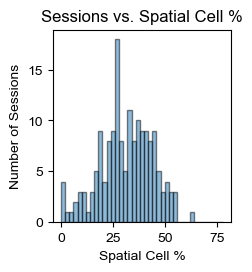

In [20]:
''' Examine spatial cell densities quickly as a sanity check'''

# Assess distribution of spatial/ngs cell densities
print('Mean, SEM spatial Cell %')
print(np.mean(perspatial), stats.sem(perspatial))

#plot spatial cell % distributions
fig, ax = plt.subplots(1,1,figsize = (2.3,2.5), sharey = True)
ax.hist(perspatial, bins = np.arange(0,80,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax.set_title('Sessions vs. Spatial Cell %')
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Spatial Cell %')

plt.show()

In [21]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [22]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mperspatial[y_ind], mperspatial[ma_ind], mperspatial[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

In [23]:
''' If you have previously classified grid & ngs cells, run this cell to load saved grid & ngs cell booleans. '''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all grid cell boolean
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(save_folder + gridcell_file)
        
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        ngscell = np.load(save_folder + ngscell_file)
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
      
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


Mean, SEM Grid Cell %; Mean, Sem NGS Cell %
14.8296889586848 0.6177677242640354 15.167797844277539 0.5583139064062825


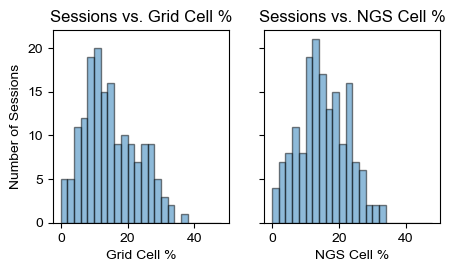

In [24]:
''' Examine grid & NGS cell densities quickly as a sanity check'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Grid Cell %; Mean, Sem NGS Cell %')
print(np.mean(pergrid), stats.sem(pergrid), np.mean(perngs), stats.sem(perngs))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,2,figsize = (5,2.5), sharey = True)
ax[0].hist(pergrid, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[0].set_title('Sessions vs. Grid Cell %')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_xlabel('Grid Cell %')

ax[1].hist(perngs, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[1].set_title('Sessions vs. NGS Cell %')
ax[1].set_xlabel('NGS Cell %')

plt.show()

In [49]:
''' Get % grid / ngs that are also spatial by session'''

sperspatialgrid = []
sperspatialngs = []
spergridspatial = []
sperngsspatial = []

totalnonspatialgrid_y = 0
totalnonspatialgrid_ma = 0
totalnonspatialgrid_aged = 0

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        spatialgridcells = []
        spatialngscells = []
        for i, c in enumerate(cell_IDs):
            if (c in spatialcells) & (c in gridcells):
                spatialgridcells = np.append(spatialgridcells, c)
                
            if (c in gridcells) & (c not in spatialcells):
                if m in SM_aged_mice:
                    totalnonspatialgrid_aged += 1
                elif m in SM_MA_mice:
                    totalnonspatialgrid_ma += 1
                else:
                    totalnonspatialgrid_y += 1
            
            if (c in spatialcells) & (c in ngscells):
                spatialngscells = np.append(spatialngscells, c)            
        
        if len(ngscells) > 0:
            sperspatialngs = np.append(sperspatialngs, 100*len(spatialngscells)/len(ngscells))
        else:
            sperspatialngs = np.append(sperspatialngs, np.nan)
         
        if len(gridcells) > 0:
            sperspatialgrid = np.append(sperspatialgrid, 100*len(spatialgridcells)/len(gridcells))
        else:
            sperspatialgrid = np.append(sperspatialgrid, np.nan)
            
        if len(spatialcells) > 0:
            sperngsspatial = np.append(sperngsspatial, 100*len(spatialngscells)/len(spatialcells))
            spergridspatial = np.append(spergridspatial, 100*len(spatialgridcells)/len(spatialcells))
        else:
            sperngsspatial = np.append(sperngsspatial, np.nan)
            spergridspatial = np.append(spergridspatial, np.nan)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Plot figures verifying classification of spatial cells

Figure 2/S3D, S3F. Not required to run subsequent sections of this notebook.

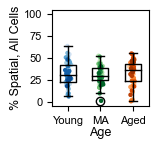


SPATIAL CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
31.9 ± 1.86 ; 30.32 ± 1.3 ; 31.62 ± 1.91
H = 1.1066008273835568
p_spatial%session = 0.5750487761521565


In [157]:
'''Spatial Cell Density Young vs. Aged Session by Age Group (Figure 2d) + Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperspatial[y_sind],sperspatial[ma_sind],sperspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Spatial, All Cells', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'age_spatialdensity_session.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'age_spatialdensity_session.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nSPATIAL CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperspatial[y_sind],sperspatial[ma_sind],sperspatial[age_sind])
print('H = ' + str(stat))
print('p_spatial%session = ' + str(p_diff))

In [77]:
print(len(y_sind), len(ma_sind), len(age_sind))

54 58 55


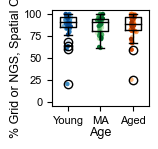


SPATIAL CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
88.16 ± 1.75 ; 87.5 ± 1.24 ; 87.24 ± 1.76
H = 0.8191218898576432
p_spatial%session = 0.6639416931192086


In [158]:
'''% Spatial Cells that are either Grid or NGS by Age Group w/ Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperngsspatial[y_sind] + spergridspatial[y_sind],sperngsspatial[ma_sind] + spergridspatial[ma_sind],sperngsspatial[age_sind] + spergridspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Grid or NGS, Spatial Cells', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'age_spatialgridorngsdensity_session.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'age_spatialgridorngsdensity_session.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nSPATIAL CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperngsspatial[y_sind] + spergridspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[y_sind] + spergridspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[ma_sind] + spergridspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[ma_sind] + spergridspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[age_sind] + spergridspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[age_sind] + spergridspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperngsspatial[y_sind] + spergridspatial[y_sind],sperngsspatial[ma_sind] + spergridspatial[ma_sind],sperngsspatial[age_sind] + spergridspatial[age_sind])
print('H = ' + str(stat))
print('p_spatial%session = ' + str(p_diff))

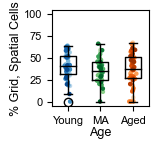


SPATIAL CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
40.56 ± 1.97 ; 35.22 ± 1.73 ; 36.76 ± 2.46
H = 4.085436999287678
p_spatial%session = 0.12967570791083297


In [159]:
'''% Grid Cells among Spatial Cells by Age Group w/ Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [spergridspatial[y_sind],spergridspatial[ma_sind],spergridspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Grid, Spatial Cells', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'age_spatialgriddensity_session.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'age_spatialgriddensity_session.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nSPATIAL CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(spergridspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergridspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergridspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergridspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergridspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergridspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(spergridspatial[y_sind],spergridspatial[ma_sind],spergridspatial[age_sind])
print('H = ' + str(stat))
print('p_spatial%session = ' + str(p_diff))

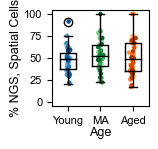


SPATIAL CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
47.59 ± 1.86 ; 52.29 ± 2.14 ; 50.49 ± 2.67
H = 2.6475967498657536
p_spatial%session = 0.2661225465611879


In [160]:
'''% NGS Cells among Spatial Cells by Age Group w/ Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperngsspatial[y_sind],sperngsspatial[ma_sind],sperngsspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% NGS, Spatial Cells', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'age_spatialngsdensity_session.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'age_spatialngsdensity_session.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nSPATIAL CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperngsspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperngsspatial[y_sind],sperngsspatial[ma_sind],sperngsspatial[age_sind])
print('H = ' + str(stat))
print('p_spatial%session = ' + str(p_diff))

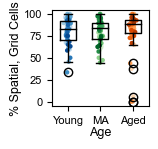


SPATIAL CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
80.31 ± 2.08 ; 80.42 ± 1.83 ; 80.37 ± 3.16
H = 1.9633448386650865
p_spatial%session = 0.37468394589150783

n young, MA, aged sessions w/ grid cells: 
53 57 53

total number of non-spatial grid cells (young, MA, aged): 
400 394 299


In [161]:
'''% Grid Cells among Spatial Cells by Age Group w/ Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperspatialgrid[y_sind][~np.isnan(sperspatialgrid[y_sind])],sperspatialgrid[ma_sind][~np.isnan(sperspatialgrid[ma_sind])],sperspatialgrid[age_sind][~np.isnan(sperspatialgrid[age_sind])]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Spatial, Grid Cells', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i][:len(y)], edgecolors = col_session[i][:len(y)], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'age_gridspatialdensity_session.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'age_gridspatialdensity_session.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nSPATIAL CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperspatialgrid[y_sind][~np.isnan(sperspatialgrid[y_sind])]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatialgrid[y_sind][~np.isnan(sperspatialgrid[y_sind])]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatialgrid[ma_sind][~np.isnan(sperspatialgrid[ma_sind])]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatialgrid[ma_sind][~np.isnan(sperspatialgrid[ma_sind])]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatialgrid[age_sind][~np.isnan(sperspatialgrid[age_sind])]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatialgrid[age_sind][~np.isnan(sperspatialgrid[age_sind])]), 2)))

stat, p_diff = stats.kruskal(sperspatialgrid[y_sind][~np.isnan(sperspatialgrid[y_sind])],sperspatialgrid[ma_sind][~np.isnan(sperspatialgrid[ma_sind])],sperspatialgrid[age_sind][~np.isnan(sperspatialgrid[age_sind])])
print('H = ' + str(stat))
print('p_spatial%session = ' + str(p_diff))

print('\nn young, MA, aged sessions w/ grid cells: ')
print(len(sperspatialgrid[y_sind][~np.isnan(sperspatialgrid[y_sind])]), len(sperspatialgrid[ma_sind][~np.isnan(sperspatialgrid[ma_sind])]), len(sperspatialgrid[age_sind][~np.isnan(sperspatialgrid[age_sind])]))

print('\ntotal number of non-spatial grid cells (young, MA, aged): ')
print(totalnonspatialgrid_y,totalnonspatialgrid_ma,totalnonspatialgrid_aged)

In [32]:
''' For spatial cells, save shuffle distributions of sparsity & coherence scores. '''

spatialsparsity = []
spatialshuffsparsity = []
spatialcoherence = []
spatialshuffcoherence = []

P99coherence = []
P99sparsity = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 

        #get cell IDs, filtered behavioral/spike data, & relevant score
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            
            P99s = np.percentile(np.ravel(shuffsparsityascores[:,sdx]), 99)
            P99c = np.percentile(np.ravel(shuffspatialacoherencescores[:,sdx]), 99)
            P99coherence = np.append(P99coherence, P99c)
            P99sparsity = np.append(P99sparsity, P99s)
        
        for i, c in enumerate(spatialcells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityascores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialacoherencescores[:,sdx]))
            coherence = spatialacoherence_scores[sdx]
            sparsity = sparsitya_scores[sdx]
            
            spatialsparsity = np.append(spatialsparsity,sparsity)
            spatialshuffsparsity = np.append(spatialshuffsparsity,shuffsparsity)
            spatialcoherence = np.append(spatialcoherence,coherence)
            spatialshuffcoherence = np.append(spatialshuffcoherence,shuffcoherence)

print('n total cells: ' + str(len(P99coherence)))
print('n total spatial cells: ' + str(len(spatialsparsity)))
print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99coherence)) + ', ' + str(stats.sem(P99coherence, nan_policy = 'omit')))
print('mean ± SEM sparsity shuffle P99: ' + str(np.nanmean(P99sparsity)) + ', ' + str(stats.sem(P99sparsity, nan_policy = 'omit')))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

n total cells: 43388
n total spatial cells: 12585
mean ± SEM coherence shuffle P99: 0.47053095825735286, 0.000873163996737665
mean ± SEM sparsity shuffle P99: 1.3739416484587894, 0.011832635763318637


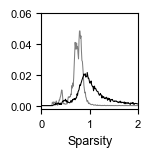

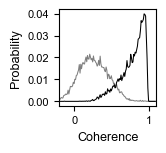


Coherence, Spatial vs. Shuff:
Mean, SEM spatial:
0.7797498712585871 0.0014406273921649738
Mean, SEM Shuffle:
0.25673193772473285 0.0017339289599544276
stat = 705.0
p_cells = 0.0

Sparsity, Spatial vs. Shuff:
Mean, SEM spatial:
1.1775427246385242 0.006503271467083012
Mean, SEM Shuffle:
0.7312761119918176 0.001246514848492602
stat = 16537.0
p_cells = 0.0


In [36]:
''' Plot Coherence & Sparsity Score Distributions vs. Shuffle for spatial Cells (Figure S3f) '''
bins = np.arange(0,2,0.01)
bsparsity, bin_edges = np.histogram(spatialsparsity, bins = bins)
pdf = bsparsity / sum(bsparsity)

shuffbsparsity, shuffbin_edges = np.histogram(spatialshuffsparsity, bins = bins)
shuffpdf = shuffbsparsity / sum(shuffbsparsity)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
#ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0,2])
#ax.set_ylim([0,0.065])
ax.set_yticks([0,0.02,0.04,0.06])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'spatialsparsity.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'spatialsparsity.svg', dpi=400, bbox_inches='tight')
plt.show()

bins = np.arange(-0.2,1.1,0.01)
bcoherence, bin_edges = np.histogram(spatialcoherence, bins = bins)
pdf = bcoherence / sum(bcoherence)
shuffcoherence, shuffbin_edges = np.histogram(spatialshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

fig, ax = plt.subplots(figsize = (1.25,1.25))
#ax.hist(spatialcoherence, 20, density = True, histtype = 'step', color = 'k')
#ax.hist(spatialshuffsparsity, 20, density = True, histtype = 'step', color = 'k', alpha = 0.5)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.1])
#ax.set_ylim([0,0.035])
ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'spatialcoherence.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'spatialcoherence.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
print('\nCoherence, Spatial vs. Shuff:')
print('Mean, SEM spatial:')
print(np.nanmean(spatialcoherence), stats.sem(spatialcoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(spatialshuffcoherence), stats.sem(spatialshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialcoherence[~np.isnan(spatialshuffcoherence)], spatialshuffcoherence[~np.isnan(spatialshuffcoherence)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#STATS
print('\nSparsity, Spatial vs. Shuff:')
print('Mean, SEM spatial:')
print(np.nanmean(spatialsparsity), stats.sem(spatialsparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(spatialshuffsparsity), stats.sem(spatialshuffsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialsparsity[~np.isnan(spatialshuffsparsity)], spatialshuffsparsity[~np.isnan(spatialshuffsparsity)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

In [85]:
''' Gather Epoch A Coherence Across Cell Types '''

y_spatialc = []
y_spatials = []
y_spatiald = []
y_NGSc = []
y_NGSs = []
y_NGSd = []
y_gridc = []
y_grids = []
y_gridd = []
y_otherc = []
y_others = []
y_otherd = []

ma_spatialc = []
ma_spatials = []
ma_spatiald = []
ma_NGSc = []
ma_NGSs = []
ma_NGSd = []
ma_gridc = []
ma_grids = []
ma_gridd = []
ma_otherc = []
ma_others = []
ma_otherd = []

aged_spatialc = []
aged_spatials = []
aged_spatiald = []
aged_NGSc = []
aged_NGSs = []
aged_NGSd = []
aged_gridc = []
aged_grids = []
aged_gridd = []
aged_otherc = []
aged_others = []
aged_otherd = []

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load data & scores
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores'] 

        #get cell IDs by group
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        #find "other" excitatory cells (non-spatial, non-grid)
        intn = d['intn'].astype(bool)
        INs = cell_IDs[intn]
    
        othercell = np.zeros(len(cell_IDs),bool)
        for i, c in enumerate(cell_IDs):
            
            if (c not in spatialcells) & (c not in gridcells) & (c not in INs):
                othercell[i] = 1
        
        d['othercell'] = othercell
        othercells = cell_IDs[othercell]
        print('% other EX cells: ' + str(np.round(len(othercells)/len(cell_IDs)*100,2)))
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #find distance tuning strength for all cells
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            autocorrelation = get.autocorr(FR[i,:], lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]

            if peaks.size > 0:
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                maxpeak_proms = np.append(maxpeak_proms,0)         
        
        #report scores for each group of cells
        spatialc = []
        spatials = []
        spatiald = []
        NGSc = []
        NGSs = []
        NGSd = []
        gridc = []
        grids = []
        gridd = []
        otherc = []
        others = []
        otherd = []
        for i, c in enumerate(cell_IDs):
        
            coherence = spatialacoherence_scores[i]
            sparsity = sparsitya_scores[i]
            distance = maxpeak_proms[i]
            
            if c in spatialcells:
                spatials = np.append(spatials,sparsity)
                spatialc = np.append(spatialc,coherence)
                spatiald = np.append(spatiald,distance)
                
            if c in ngscells:
                NGSs = np.append(NGSs,sparsity)
                NGSc = np.append(NGSc,coherence)
                NGSd = np.append(NGSd,distance)
                
            if c in othercells:
                others = np.append(others,sparsity)
                otherc = np.append(otherc,coherence)
                otherd = np.append(otherd,distance)
                
            if c in gridcells:
                grids = np.append(grids,sparsity)
                gridc = np.append(gridc,coherence)
                gridd = np.append(gridd,distance)
        
        #save results
        if m in SM_aged_mice:
            aged_spatialc = np.append(aged_spatialc, spatialc)
            aged_spatials = np.append(aged_spatials, spatials)
            aged_spatiald = np.append(aged_spatiald, spatiald)
            aged_NGSc = np.append(aged_NGSc, NGSc)
            aged_NGSs = np.append(aged_NGSs, NGSs)
            aged_NGSd = np.append(aged_NGSd, NGSd)
            aged_gridc = np.append(aged_gridc, gridc)
            aged_grids = np.append(aged_grids, grids)
            aged_gridd = np.append(aged_gridd, gridd)
            aged_otherc = np.append(aged_otherc, otherc)
            aged_others = np.append(aged_others, others)
            aged_otherd = np.append(aged_otherd, otherd)
        elif m in SM_MA_mice:
            ma_spatialc = np.append(ma_spatialc, spatialc)
            ma_spatials = np.append(ma_spatials, spatials)
            ma_spatiald = np.append(ma_spatiald, spatiald)
            ma_NGSc = np.append(ma_NGSc, NGSc)
            ma_NGSs = np.append(ma_NGSs, NGSs)
            ma_NGSd = np.append(ma_NGSd, NGSd)
            ma_gridc = np.append(ma_gridc, gridc)
            ma_grids = np.append(ma_grids, grids)
            ma_gridd = np.append(ma_gridd, gridd)
            ma_otherc = np.append(ma_otherc, otherc)
            ma_others = np.append(ma_others, others)
            ma_otherd = np.append(ma_otherd, otherd)
        else:
            y_spatialc = np.append(y_spatialc, spatialc)
            y_spatials = np.append(y_spatials, spatials)
            y_spatiald = np.append(y_spatiald, spatiald)
            y_NGSc = np.append(y_NGSc, NGSc)
            y_NGSs = np.append(y_NGSs, NGSs)
            y_NGSd = np.append(y_NGSd, NGSd)
            y_gridc = np.append(y_gridc, gridc)
            y_grids = np.append(y_grids, grids)
            y_gridd = np.append(y_gridd, gridd)
            y_otherc = np.append(y_otherc, otherc)
            y_others = np.append(y_others, others)
            y_otherd = np.append(y_otherd, otherd)

  0%|          | 0/3 [00:00<?, ?it/s]

% other EX cells: 45.37
% other EX cells: 61.48
% other EX cells: 33.33


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 21.82
% other EX cells: 31.69
% other EX cells: 32.0
% other EX cells: 32.58
% other EX cells: 44.17
% other EX cells: 42.11


  0%|          | 0/4 [00:00<?, ?it/s]

% other EX cells: 48.08
% other EX cells: 17.44
% other EX cells: 32.43
% other EX cells: 45.25


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 68.31
% other EX cells: 27.78
% other EX cells: 40.89
% other EX cells: 33.74
% other EX cells: 64.88
% other EX cells: 38.04


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 29.23
% other EX cells: 36.06
% other EX cells: 37.75
% other EX cells: 58.55
% other EX cells: 44.93
% other EX cells: 75.71


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 61.2
% other EX cells: 33.63
% other EX cells: 34.97
% other EX cells: 35.61
% other EX cells: 35.23
% other EX cells: 30.73


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 44.55
% other EX cells: 33.33
% other EX cells: 40.25
% other EX cells: 35.12
% other EX cells: 34.02
% other EX cells: 27.92


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 22.91
% other EX cells: 26.46
% other EX cells: 29.67
% other EX cells: 52.3
% other EX cells: 31.16
% other EX cells: 57.21


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 29.27
% other EX cells: 30.9
% other EX cells: 44.84
% other EX cells: 52.08
% other EX cells: 40.38
% other EX cells: 30.7


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 30.69
% other EX cells: 29.0
% other EX cells: 35.05
% other EX cells: 28.82
% other EX cells: 33.52
% other EX cells: 31.76


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 45.76
% other EX cells: 40.96
% other EX cells: 43.65
% other EX cells: 45.57
% other EX cells: 41.1
% other EX cells: 49.55


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 21.1
% other EX cells: 30.24
% other EX cells: 47.46
% other EX cells: 43.42
% other EX cells: 31.52
% other EX cells: 47.4


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 27.88
% other EX cells: 35.76
% other EX cells: 33.73
% other EX cells: 42.01
% other EX cells: 40.0
% other EX cells: 42.96


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 30.93
% other EX cells: 33.64
% other EX cells: 43.44
% other EX cells: 38.76
% other EX cells: 38.1
% other EX cells: 37.37


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 24.9
% other EX cells: 17.42
% other EX cells: 35.62
% other EX cells: 36.96
% other EX cells: 50.44
% other EX cells: 54.86


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 38.51
% other EX cells: 40.43
% other EX cells: 47.05
% other EX cells: 14.63
% other EX cells: 49.48
% other EX cells: 48.12


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 45.51
% other EX cells: 40.07
% other EX cells: 33.04
% other EX cells: 50.83
% other EX cells: 23.88
% other EX cells: 32.1


  0%|          | 0/4 [00:00<?, ?it/s]

% other EX cells: 38.05
% other EX cells: 33.96
% other EX cells: 33.33
% other EX cells: 49.22


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 46.28
% other EX cells: 41.94
% other EX cells: 43.05
% other EX cells: 39.31
% other EX cells: 47.6
% other EX cells: 36.69


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 51.93
% other EX cells: 34.71
% other EX cells: 40.23
% other EX cells: 70.94
% other EX cells: 44.36
% other EX cells: 49.28


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 56.78
% other EX cells: 32.0
% other EX cells: 57.84
% other EX cells: 33.33
% other EX cells: 15.38
% other EX cells: 34.66


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 33.74
% other EX cells: 41.87
% other EX cells: 53.23
% other EX cells: 41.0
% other EX cells: 52.67
% other EX cells: 58.45


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 34.04
% other EX cells: 36.63
% other EX cells: 35.89
% other EX cells: 38.76
% other EX cells: 38.74
% other EX cells: 34.88


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 62.4
% other EX cells: 65.66
% other EX cells: 57.82
% other EX cells: 19.01
% other EX cells: 22.83
% other EX cells: 39.65


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 44.61
% other EX cells: 63.87
% other EX cells: 50.61
% other EX cells: 49.89
% other EX cells: 35.32
% other EX cells: 40.78


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 57.14
% other EX cells: 42.9
% other EX cells: 40.91
% other EX cells: 43.73
% other EX cells: 44.38
% other EX cells: 61.99


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 43.93
% other EX cells: 51.83
% other EX cells: 48.57
% other EX cells: 65.0
% other EX cells: 60.69
% other EX cells: 66.02


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 35.0
% other EX cells: 43.85
% other EX cells: 46.75
% other EX cells: 55.13
% other EX cells: 43.63
% other EX cells: 32.6


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 35.56
% other EX cells: 47.28
% other EX cells: 51.15
% other EX cells: 45.22
% other EX cells: 47.49
% other EX cells: 44.36


n young grid, ngs, spatial, other EX cells: 
2441 2154 4673 6972
n MA grid, ngs, spatial, other EX cells: 
2035 2347 4513 6147
n aged grid, ngs, spatial, other EX cells: 
2032 2058 4278 5285


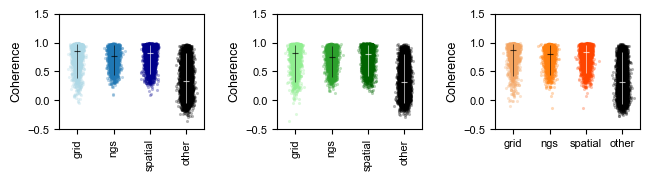

In [105]:
''' Plot Young, MA, Aged Coherence by Cell Type '''

# plotting params
gs = gridspec.GridSpec(1, 3, wspace=0.5) # each subplot will be an age group
f = plt.figure(figsize=(7.5, 1.5))
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5, 7])

# length of arrays for young cell types
n_gc = y_gridc.shape[0]
n_ngs = y_NGSc.shape[0]
n_sp = y_spatialc.shape[0]
n_other = y_otherc.shape[0]

print('n young grid, ngs, spatial, other EX cells: ')
print(n_gc, n_ngs, n_sp, n_other)

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# YOUNG COHERENCE
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(n_gc, POSITIONS[0])+j_gc, y_gridc, s=PT_SIZE, lw=PT_LW,
            color='lightblue', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, y_NGSc, s=PT_SIZE, lw=PT_LW, 
            color='C0', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_sp, POSITIONS[2])+j_sp, y_spatialc, s=PT_SIZE, lw=PT_LW, 
            color='darkblue', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_other, POSITIONS[3])+j_other, y_otherc, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(y_gridc), np.median(y_NGSc), np.median(y_spatialc), np.median(y_otherc)])
dFR_5 = np.asarray([np.percentile(y_gridc, 5), np.percentile(y_NGSc, 5), np.percentile(y_spatialc, 5), np.percentile(y_otherc, 5)])
dFR_95 = np.asarray([np.percentile(y_gridc, 95), np.percentile(y_NGSc, 95), np.percentile(y_spatialc, 95), np.percentile(y_otherc, 95)])
ax0.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax0.tick_params(which='major', labelsize=8)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax0.set_yticks([-0.5,0,0.5,1.0,1.5])
ax0.set_ylim([-0.5,1.5])
ax0.set_ylabel('Coherence', fontsize=9)

# length of arrays for MA cell types
n_gc = ma_gridc.shape[0]
n_ngs = ma_NGSc.shape[0]
n_sp = ma_spatialc.shape[0]
n_other = ma_otherc.shape[0]

print('n MA grid, ngs, spatial, other EX cells: ')
print(n_gc, n_ngs, n_sp, n_other)

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# MA COHERENCE
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(n_gc, POSITIONS[0])+j_gc, ma_gridc, s=PT_SIZE, lw=PT_LW,
            color='lightgreen', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, ma_NGSc, s=PT_SIZE, lw=PT_LW, 
            color='C2', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_sp, POSITIONS[2])+j_sp, ma_spatialc, s=PT_SIZE, lw=PT_LW, 
            color='darkgreen', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_other, POSITIONS[3])+j_other, ma_otherc, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(ma_gridc), np.median(ma_NGSc), np.median(ma_spatialc), np.median(ma_otherc)])
dFR_5 = np.asarray([np.percentile(ma_gridc, 5), np.percentile(ma_NGSc, 5), np.percentile(ma_spatialc, 5), np.percentile(ma_otherc, 5)])
dFR_95 = np.asarray([np.percentile(ma_gridc, 95), np.percentile(ma_NGSc, 95), np.percentile(ma_spatialc, 95), np.percentile(ma_otherc, 95)])
ax1.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax1.tick_params(which='major', labelsize=8)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax1.set_yticks([-0.5,0,0.5,1.0,1.5])
ax1.set_ylim([-0.5,1.5])
ax1.set_ylabel('Coherence', fontsize=9)

# length of arrays for aged cell types
n_gc = aged_gridc.shape[0]
n_ngs = aged_NGSc.shape[0]
n_sp = aged_spatialc.shape[0]
n_other = aged_otherc.shape[0]

print('n aged grid, ngs, spatial, other EX cells: ')
print(n_gc, n_ngs, n_sp, n_other)

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# Aged COHERENCE
ax2 = plt.subplot(gs[2])
ax2.scatter(np.full(n_gc, POSITIONS[0])+j_gc, aged_gridc, s=PT_SIZE, lw=PT_LW,
            color='sandybrown', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, aged_NGSc, s=PT_SIZE, lw=PT_LW, 
            color='C1', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_sp, POSITIONS[2])+j_sp, aged_spatialc, s=PT_SIZE, lw=PT_LW, 
            color='orangered', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_other, POSITIONS[3])+j_other, aged_otherc, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(aged_gridc), np.median(aged_NGSc), np.median(aged_spatialc), np.median(aged_otherc)])
dFR_5 = np.asarray([np.percentile(aged_gridc, 5), np.percentile(aged_NGSc, 5), np.percentile(aged_spatialc, 5), np.percentile(aged_otherc, 5)])
dFR_95 = np.asarray([np.percentile(aged_gridc, 95), np.percentile(aged_NGSc, 95), np.percentile(aged_spatialc, 95), np.percentile(aged_otherc, 95)])
ax2.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax2.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax2.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax2.tick_params(which='major', labelsize=8)
ax2.set_xticks(POSITIONS)
ax2.set_xticklabels(['grid', 'ngs', 'spatial', 'other'])
ax2.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax2.set_yticks([-0.5,0,0.5,1.0,1.5])
ax2.set_ylim([-0.5,1.5])
ax2.set_ylabel('Coherence', fontsize=9)

#f.savefig(save_folder + 'Reviewer5B.png', dpi=400, bbox_inches='tight')
#f.savefig(save_folder + 'Reviewer5B.svg', dpi=400, bbox_inches='tight')

plt.show()

In [107]:
''' Statistics on Coherence within Age Group, across Cell Types'''

print('Young Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(y_gridc), 4)) + ' ± ' + str(np.round(stats.sem(y_gridc), 4)) + ' ; ' 
      + str(np.round(np.mean(y_NGSc), 4)) + ' ± ' + str(np.round(stats.sem(y_NGSc), 4)) + ' ; ' 
      + str(np.round(np.mean(y_spatialc), 4)) + ' ± ' + str(np.round(stats.sem(y_spatialc), 4)) + ' ; ' 
      + str(np.round(np.mean(y_otherc), 4)) + ' ± ' + str(np.round(stats.sem(y_otherc), 4)))
      
stat, p_diff = stats.kruskal(y_gridc,y_NGSc,y_spatialc)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(y_gridc,y_otherc)
print('grid vs. other, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(y_NGSc,y_otherc)
print('NGS vs. other, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(y_spatialc,y_otherc)
print('spatial vs. other, p = ' + str(p_diff))   
      
print('\nMA Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(ma_gridc), 4)) + ' ± ' + str(np.round(stats.sem(ma_gridc), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_NGSc), 4)) + ' ± ' + str(np.round(stats.sem(ma_NGSc), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_spatialc), 4)) + ' ± ' + str(np.round(stats.sem(ma_spatialc), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_otherc), 4)) + ' ± ' + str(np.round(stats.sem(ma_otherc), 4)))
      
stat, p_diff = stats.kruskal(ma_gridc,ma_NGSc,ma_spatialc)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(ma_gridc,ma_otherc)
print('grid vs. other, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(ma_NGSc,ma_otherc)
print('NGS vs. other, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(ma_spatialc,ma_otherc)
print('spatial vs. other, p = ' + str(p_diff))   
      
print('\nAged Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(aged_gridc), 4)) + ' ± ' + str(np.round(stats.sem(aged_gridc), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_NGSc), 4)) + ' ± ' + str(np.round(stats.sem(aged_NGSc), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_spatialc), 4)) + ' ± ' + str(np.round(stats.sem(aged_spatialc), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_otherc), 4)) + ' ± ' + str(np.round(stats.sem(aged_otherc), 4)))
      
stat, p_diff = stats.kruskal(aged_gridc,aged_NGSc,aged_spatialc)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(aged_gridc,aged_otherc)
print('grid vs. other, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(aged_NGSc,aged_otherc)
print('NGS vs. other, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(aged_spatialc,aged_otherc)
print('spatial vs. other, p = ' + str(p_diff))   

Young Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7925 ± 0.0038 ; 0.7412 ± 0.0035 ; 0.7849 ± 0.0023 ; 0.3567 ± 0.0033
H = 230.36705826998917
p = 9.471720860106422e-51
grid vs. other, p = 0.0
NGS vs. other, p = 0.0
spatial vs. other, p = 0.0

MA Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7508 ± 0.0046 ; 0.7262 ± 0.0035 ; 0.756 ± 0.0025 ; 0.3394 ± 0.0034
H = 85.74829105040929
p = 2.3988063073410617e-19
grid vs. other, p = 0.0
NGS vs. other, p = 0.0
spatial vs. other, p = 0.0

Aged Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.8031 ± 0.004 ; 0.7606 ± 0.0036 ; 0.7953 ± 0.0024 ; 0.3436 ± 0.0039
H = 158.51058653877442
p = 3.8006989552272736e-35
grid vs. other, p = 0.0
NGS vs. other, p = 0.0
spatial vs. other, p = 0.0


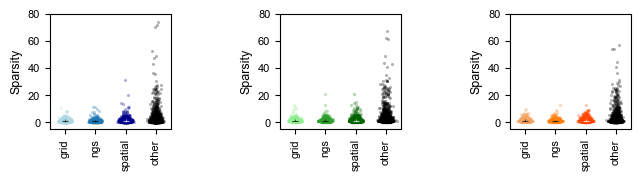

In [112]:
''' Plot Young, MA, Aged Sparsity by Cell Type '''

# plotting params
gs = gridspec.GridSpec(1, 3, wspace=0.9) # each subplot will be an age group
f = plt.figure(figsize=(7.5, 1.5))
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5, 7])

# length of arrays for young cell types
n_gc = y_grids.shape[0]
n_ngs = y_NGSs.shape[0]
n_sp = y_spatials.shape[0]
n_other = y_others.shape[0]

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# YOUNG Sparsity
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(n_gc, POSITIONS[0])+j_gc, y_grids, s=PT_SIZE, lw=PT_LW,
            color='lightblue', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, y_NGSs, s=PT_SIZE, lw=PT_LW, 
            color='C0', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_sp, POSITIONS[2])+j_sp, y_spatials, s=PT_SIZE, lw=PT_LW, 
            color='darkblue', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_other, POSITIONS[3])+j_other, y_others, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(y_grids), np.median(y_NGSs), np.median(y_spatials), np.median(y_others)])
dFR_5 = np.asarray([np.percentile(y_grids, 5), np.percentile(y_NGSs, 5), np.percentile(y_spatials, 5), np.percentile(y_others, 5)])
dFR_95 = np.asarray([np.percentile(y_grids, 95), np.percentile(y_NGSs, 95), np.percentile(y_spatials, 95), np.percentile(y_others, 95)])
ax0.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax0.tick_params(which='major', labelsize=8)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax0.set_ylim([-5,80])
ax0.set_yticks([0,20,40,60,80])
ax0.set_ylabel('Sparsity', fontsize=9)

# length of arrays for MA cell types
n_gc = ma_grids.shape[0]
n_ngs = ma_NGSs.shape[0]
n_sp = ma_spatials.shape[0]
n_other = ma_others.shape[0]

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# MA Sparsity
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(n_gc, POSITIONS[0])+j_gc, ma_grids, s=PT_SIZE, lw=PT_LW,
            color='lightgreen', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, ma_NGSs, s=PT_SIZE, lw=PT_LW, 
            color='C2', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_sp, POSITIONS[2])+j_sp, ma_spatials, s=PT_SIZE, lw=PT_LW, 
            color='darkgreen', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_other, POSITIONS[3])+j_other, ma_others, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(ma_grids), np.median(ma_NGSs), np.median(ma_spatials), np.median(ma_others)])
dFR_5 = np.asarray([np.percentile(ma_grids, 5), np.percentile(ma_NGSs, 5), np.percentile(ma_spatials, 5), np.percentile(ma_others, 5)])
dFR_95 = np.asarray([np.percentile(ma_grids, 95), np.percentile(ma_NGSs, 95), np.percentile(ma_spatials, 95), np.percentile(ma_others, 95)])
ax1.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax1.tick_params(which='major', labelsize=8)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax1.set_ylim([-5,80])
ax1.set_yticks([0,20,40,60,80])
ax1.set_ylabel('Sparsity', fontsize=9)

# length of arrays for aged cell types
n_gc = aged_grids.shape[0]
n_ngs = aged_NGSs.shape[0]
n_sp = aged_spatials.shape[0]
n_other = aged_others.shape[0]

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# Aged Sparsity
ax2 = plt.subplot(gs[2])
ax2.scatter(np.full(n_gc, POSITIONS[0])+j_gc, aged_grids, s=PT_SIZE, lw=PT_LW,
            color='sandybrown', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, aged_NGSs, s=PT_SIZE, lw=PT_LW, 
            color='C1', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_sp, POSITIONS[2])+j_sp, aged_spatials, s=PT_SIZE, lw=PT_LW, 
            color='orangered', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_other, POSITIONS[3])+j_other, aged_others, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(aged_grids), np.median(aged_NGSs), np.median(aged_spatials), np.median(aged_others)])
dFR_5 = np.asarray([np.percentile(aged_grids, 5), np.percentile(aged_NGSs, 5), np.percentile(aged_spatials, 5), np.percentile(aged_others, 5)])
dFR_95 = np.asarray([np.percentile(aged_grids, 95), np.percentile(aged_NGSs, 95), np.percentile(aged_spatials, 95), np.percentile(aged_others, 95)])
ax2.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax2.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax2.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax2.tick_params(which='major', labelsize=8)
ax2.set_xticks(POSITIONS)
ax2.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax2.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax2.set_ylim([-5,80])
ax2.set_yticks([0,20,40,60,80])
ax2.set_ylabel('Sparsity', fontsize=9)

#f.savefig(save_folder + 'Reviewer5C.png', dpi=400, bbox_inches='tight')
#f.savefig(save_folder + 'Reviewer5C.svg', dpi=400, bbox_inches='tight')

plt.show()

In [115]:
''' Statistics on Sparsity within Age Group, across Cell Types'''

print('Young Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(y_grids), 4)) + ' ± ' + str(np.round(stats.sem(y_grids), 4)) + ' ; ' 
      + str(np.round(np.mean(y_NGSs), 4)) + ' ± ' + str(np.round(stats.sem(y_NGSs), 4)) + ' ; ' 
      + str(np.round(np.mean(y_spatials), 4)) + ' ± ' + str(np.round(stats.sem(y_spatials), 4)) + ' ; ' 
      + str(np.round(np.nanmean(y_others), 4)) + ' ± ' + str(np.round(stats.sem(y_others, nan_policy = 'omit'), 4)))
      
stat, p_diff = stats.kruskal(y_grids,y_NGSs,y_spatials)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(y_grids,y_others[~np.isnan(y_others)])
print('grid vs. other, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(y_NGSs,y_others[~np.isnan(y_others)])
print('NGS vs. other, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(y_spatials,y_others[~np.isnan(y_others)])
print('spatial vs. other, p = ' + str(p_diff))   
      
print('\nMA Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(ma_grids), 4)) + ' ± ' + str(np.round(stats.sem(ma_grids), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_NGSs), 4)) + ' ± ' + str(np.round(stats.sem(ma_NGSs), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_spatials), 4)) + ' ± ' + str(np.round(stats.sem(ma_spatials), 4)) + ' ; ' 
      + str(np.round(np.nanmean(ma_others), 4)) + ' ± ' + str(np.round(stats.sem(ma_others, nan_policy = 'omit'), 4)))
      
stat, p_diff = stats.kruskal(ma_grids,ma_NGSs,ma_spatials)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(ma_grids,ma_others[~np.isnan(ma_others)])
print('grid vs. other, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(ma_NGSs,ma_others[~np.isnan(ma_others)])
print('NGS vs. other, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(ma_spatials,ma_others[~np.isnan(ma_others)])
print('spatial vs. other, p = ' + str(p_diff))   
      
print('\nAged Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(aged_grids), 4)) + ' ± ' + str(np.round(stats.sem(aged_grids), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_NGSs), 4)) + ' ± ' + str(np.round(stats.sem(aged_NGSs), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_spatials), 4)) + ' ± ' + str(np.round(stats.sem(aged_spatials), 4)) + ' ; ' 
      + str(np.round(np.nanmean(aged_others), 4)) + ' ± ' + str(np.round(stats.sem(aged_others, nan_policy = 'omit'), 4)))
      
stat, p_diff = stats.kruskal(aged_grids,aged_NGSs,aged_spatials)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(aged_grids,aged_others[~np.isnan(aged_others)])
print('grid vs. other, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(aged_NGSs,aged_others[~np.isnan(aged_others)])
print('NGS vs. other, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(aged_spatials,aged_others[~np.isnan(aged_others)])
print('spatial vs. other, p = ' + str(p_diff))   

Young Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.1504 ± 0.014 ; 1.0353 ± 0.0153 ; 1.1754 ± 0.014 ; 1.5945 ± 0.0344
H = 112.08884213920983
p = 4.573168337836307e-25
grid vs. other, p = 0.0005609632800080448
NGS vs. other, p = 8.904989102092204e-38
spatial vs. other, p = 6.957897417597908e-08

MA Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.2813 ± 0.0176 ; 1.1736 ± 0.017 ; 1.2981 ± 0.0146 ; 1.9336 ± 0.0401
H = 84.83678533776707
p = 3.7837822250099377e-19
grid vs. other, p = 3.6373220060027257e-26
NGS vs. other, p = 6.72969553135732e-90
spatial vs. other, p = 1.974650472380726e-55

Aged Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.2607 ± 0.0165 ; 1.0905 ± 0.0144 ; 1.233 ± 0.0123 ; 1.749 ± 0.0399
H = 172.832961187477
p = 2.9498459245900744e-38
grid vs. other, p = 0.00010701449429187409
NGS vs. other, p = 1.6329135056985133e-61
spatial vs. other, p = 2.0492700149120652e-23


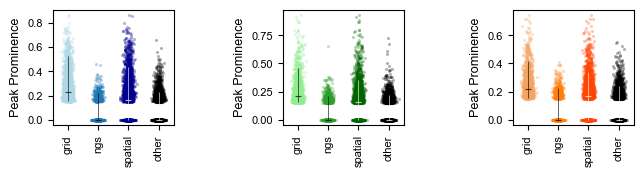

In [116]:
''' Plot Young, MA, Aged Distance Tuning by Cell Type '''

# plotting params
gs = gridspec.GridSpec(1, 3, wspace=0.9) # each subplot will be an age group
f = plt.figure(figsize=(7.5, 1.5))
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5, 7])

# length of arrays for young cell types
n_gc = y_gridd.shape[0]
n_ngs = y_NGSd.shape[0]
n_sp = y_spatiald.shape[0]
n_other = y_otherd.shape[0]

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# YOUNG Sparsity
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(n_gc, POSITIONS[0])+j_gc, y_gridd, s=PT_SIZE, lw=PT_LW,
            color='lightblue', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, y_NGSd, s=PT_SIZE, lw=PT_LW, 
            color='C0', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_sp, POSITIONS[2])+j_sp, y_spatiald, s=PT_SIZE, lw=PT_LW, 
            color='darkblue', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_other, POSITIONS[3])+j_other, y_otherd, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(y_gridd), np.median(y_NGSd), np.median(y_spatiald), np.median(y_otherd)])
dFR_5 = np.asarray([np.percentile(y_gridd, 5), np.percentile(y_NGSd, 5), np.percentile(y_spatiald, 5), np.percentile(y_otherd, 5)])
dFR_95 = np.asarray([np.percentile(y_gridd, 95), np.percentile(y_NGSd, 95), np.percentile(y_spatiald, 95), np.percentile(y_otherd, 95)])
ax0.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax0.tick_params(which='major', labelsize=8)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax0.set_ylabel('Peak Prominence', fontsize=9)

# length of arrays for MA cell types
n_gc = ma_gridd.shape[0]
n_ngs = ma_NGSd.shape[0]
n_sp = ma_spatiald.shape[0]
n_other = ma_otherd.shape[0]

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# MA Sparsity
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(n_gc, POSITIONS[0])+j_gc, ma_gridd, s=PT_SIZE, lw=PT_LW,
            color='lightgreen', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, ma_NGSd, s=PT_SIZE, lw=PT_LW, 
            color='C2', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_sp, POSITIONS[2])+j_sp, ma_spatiald, s=PT_SIZE, lw=PT_LW, 
            color='darkgreen', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_other, POSITIONS[3])+j_other, ma_otherd, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(ma_gridd), np.median(ma_NGSd), np.median(ma_spatiald), np.median(ma_otherd)])
dFR_5 = np.asarray([np.percentile(ma_gridd, 5), np.percentile(ma_NGSd, 5), np.percentile(ma_spatiald, 5), np.percentile(ma_otherd, 5)])
dFR_95 = np.asarray([np.percentile(ma_gridd, 95), np.percentile(ma_NGSd, 95), np.percentile(ma_spatiald, 95), np.percentile(ma_otherd, 95)])
ax1.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax1.tick_params(which='major', labelsize=8)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax1.set_ylabel('Peak Prominence', fontsize=9)

# length of arrays for aged cell types
n_gc = aged_gridd.shape[0]
n_ngs = aged_NGSd.shape[0]
n_sp = aged_spatiald.shape[0]
n_other = aged_otherd.shape[0]

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_ngs = np.random.randn(n_ngs) * JIT
j_sp = np.random.randn(n_sp) * JIT
j_other = np.random.randn(n_other) * JIT

# Aged Sparsity
ax2 = plt.subplot(gs[2])
ax2.scatter(np.full(n_gc, POSITIONS[0])+j_gc, aged_gridd, s=PT_SIZE, lw=PT_LW,
            color='sandybrown', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_ngs, POSITIONS[1])+j_ngs, aged_NGSd, s=PT_SIZE, lw=PT_LW, 
            color='C1', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_sp, POSITIONS[2])+j_sp, aged_spatiald, s=PT_SIZE, lw=PT_LW, 
            color='orangered', alpha=0.3, zorder=1)
ax2.scatter(np.full(n_other, POSITIONS[3])+j_other, aged_otherd, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(aged_gridd), np.median(aged_NGSd), np.median(aged_spatiald), np.median(aged_otherd)])
dFR_5 = np.asarray([np.percentile(aged_gridd, 5), np.percentile(aged_NGSd, 5), np.percentile(aged_spatiald, 5), np.percentile(aged_otherd, 5)])
dFR_95 = np.asarray([np.percentile(aged_gridd, 95), np.percentile(aged_NGSd, 95), np.percentile(aged_spatiald, 95), np.percentile(aged_otherd, 95)])
ax2.plot(POSITIONS[:-2], dFR_medians[:-2], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax2.plot(POSITIONS[-2:], dFR_medians[-2:], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax2.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w','w'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax2.tick_params(which='major', labelsize=8)
ax2.set_xticks(POSITIONS)
ax2.set_xticklabels(['grid', 'ngs', 'spatial', 'other'], rotation=90)
ax2.set_xlim(POSITIONS[0] - 1, POSITIONS[3] + 1)
ax2.set_ylabel('Peak Prominence', fontsize=9)

#f.savefig(save_folder + 'Reviewer5D.png', dpi=400, bbox_inches='tight')
#f.savefig(save_folder + 'Reviewer5D.svg', dpi=400, bbox_inches='tight')

plt.show()

In [118]:
''' Statistics on Distance Tuning within Age Group, across Cell Types'''

print('Young Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(y_gridd), 4)) + ' ± ' + str(np.round(stats.sem(y_gridd), 4)) + ' ; ' 
      + str(np.round(np.mean(y_NGSd), 4)) + ' ± ' + str(np.round(stats.sem(y_NGSd), 4)) + ' ; ' 
      + str(np.round(np.mean(y_spatiald), 4)) + ' ± ' + str(np.round(stats.sem(y_spatiald), 4)) + ' ; ' 
      + str(np.round(np.mean(y_otherd), 4)) + ' ± ' + str(np.round(stats.sem(y_otherd), 4)))
      
stat, p_diff = stats.kruskal(y_gridd,y_NGSd,y_spatiald)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(y_NGSd,y_gridd)
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(y_spatiald,y_gridd)
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(y_otherd,y_gridd)
print('other vs. grid, p = ' + str(p_diff))   
      
print('\nMA Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(ma_gridd), 4)) + ' ± ' + str(np.round(stats.sem(ma_gridd), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_NGSd), 4)) + ' ± ' + str(np.round(stats.sem(ma_NGSd), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_spatiald), 4)) + ' ± ' + str(np.round(stats.sem(ma_spatiald), 4)) + ' ; ' 
      + str(np.round(np.mean(ma_otherd), 4)) + ' ± ' + str(np.round(stats.sem(ma_otherd), 4)))
      
stat, p_diff = stats.kruskal(ma_gridd,ma_NGSd,ma_spatiald)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(ma_NGSd,ma_gridd)
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(ma_spatiald,ma_gridd)
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(ma_otherd,ma_gridd)
print('other vs. grid, p = ' + str(p_diff)) 
      
print('\nAged Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(aged_gridd), 4)) + ' ± ' + str(np.round(stats.sem(aged_gridd), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_NGSd), 4)) + ' ± ' + str(np.round(stats.sem(aged_NGSd), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_spatiald), 4)) + ' ± ' + str(np.round(stats.sem(aged_spatiald), 4)) + ' ; ' 
      + str(np.round(np.mean(aged_otherd), 4)) + ' ± ' + str(np.round(stats.sem(aged_otherd), 4)))
      
stat, p_diff = stats.kruskal(aged_gridd,aged_NGSd,aged_spatiald)
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(aged_NGSd,aged_gridd)
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(aged_spatiald,aged_gridd)
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(aged_otherd,aged_gridd)
print('other vs. grid, p = ' + str(p_diff))  

Young Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2692 ± 0.0024 ; 0.0419 ± 0.0018 ; 0.1479 ± 0.0022 ; 0.0579 ± 0.0011
H = 2825.8707304756886
p = 0.0
NGS vs. grid, p = 0.0
spatial vs. grid, p = 5.322006973470483e-231
other vs. grid, p = 0.0

MA Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2459 ± 0.0023 ; 0.0502 ± 0.0018 ; 0.1268 ± 0.002 ; 0.0585 ± 0.0012
H = 2495.8767078447986
p = 0.0
NGS vs. grid, p = 0.0
spatial vs. grid, p = 7.9068007257981e-242
other vs. grid, p = 0.0

Aged Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.242 ± 0.0019 ; 0.0497 ± 0.002 ; 0.1355 ± 0.002 ; 0.0672 ± 0.0014
H = 2339.925598608402
p = 0.0
NGS vs. grid, p = 0.0
spatial vs. grid, p = 8.910248180179592e-205
other vs. grid, p = 0.0


In [119]:
''' Gather Block A Coherence & Sparsity & Distance Tuning Across Cell Types by Session '''

sspatialc = []
sspatials = []
sspatiald = []
sNGSc = []
sNGSs = []
sNGSd = []
sgridc = []
sgrids = []
sgridd = []
sotherc = []
sothers = []
sotherd = []

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load data & scores
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores'] 

        #get cell IDs by group
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        #find "other" excitatory cells (non-spatial, non-grid)
        intn = d['intn'].astype(bool)
        INs = cell_IDs[intn]
    
        othercell = np.zeros(len(cell_IDs),bool)
        for i, c in enumerate(cell_IDs):
            
            if (c not in spatialcells) & (c not in gridcells) & (c not in INs):
                othercell[i] = 1
        
        d['othercell'] = othercell
        othercells = cell_IDs[othercell]
        print('% other EX cells: ' + str(np.round(len(othercells)/len(cell_IDs)*100,2)))
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #find distance tuning strength for all cells
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            autocorrelation = get.autocorr(FR[i,:], lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]

            if peaks.size > 0:
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                maxpeak_proms = np.append(maxpeak_proms,0)         
        
        #report scores for each group of cells
        spatialc = []
        spatials = []
        spatiald = []
        NGSc = []
        NGSs = []
        NGSd = []
        gridc = []
        grids = []
        gridd = []
        otherc = []
        others = []
        otherd = []
        for i, c in enumerate(cell_IDs):
        
            coherence = spatialacoherence_scores[i]
            sparsity = sparsitya_scores[i]
            distance = maxpeak_proms[i]
            
            if c in spatialcells:
                spatials = np.append(spatials,sparsity)
                spatialc = np.append(spatialc,coherence)
                spatiald = np.append(spatiald,distance)
                
            if c in ngscells:
                NGSs = np.append(NGSs,sparsity)
                NGSc = np.append(NGSc,coherence)
                NGSd = np.append(NGSd,distance)
                
            if c in othercells:
                others = np.append(others,sparsity)
                otherc = np.append(otherc,coherence)
                otherd = np.append(otherd,distance)
                
            if c in gridcells:
                grids = np.append(grids,sparsity)
                gridc = np.append(gridc,coherence)
                gridd = np.append(gridd,distance)
        
        #save results
        sspatialc = np.append(sspatialc, np.mean(spatialc))
        sspatials = np.append(sspatials, np.nanmean(spatials))
        sspatiald = np.append(sspatiald, np.mean(spatiald))
        sNGSc = np.append(sNGSc, np.mean(NGSc))
        sNGSs = np.append(sNGSs, np.nanmean(NGSs))
        sNGSd = np.append(sNGSd, np.mean(NGSd))
        if len(gridcells) > 0:
            sgridc = np.append(sgridc, np.mean(gridc))
            sgrids = np.append(sgrids, np.nanmean(grids))
            sgridd = np.append(sgridd, np.mean(gridd))
        else:
            sgridc = np.append(sgridc, np.nan)
            sgrids = np.append(sgrids, np.nan)
            sgridd = np.append(sgridd, np.nan)
        sotherc = np.append(sotherc, np.mean(otherc))
        sothers = np.append(sothers, np.nanmean(others))
        sotherd = np.append(sotherd, np.mean(otherd))

  0%|          | 0/3 [00:00<?, ?it/s]

% other EX cells: 45.37
% other EX cells: 61.48
% other EX cells: 33.33


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 21.82
% other EX cells: 31.69
% other EX cells: 32.0
% other EX cells: 32.58
% other EX cells: 44.17
% other EX cells: 42.11


  0%|          | 0/4 [00:00<?, ?it/s]

% other EX cells: 48.08
% other EX cells: 17.44
% other EX cells: 32.43
% other EX cells: 45.25


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 68.31
% other EX cells: 27.78
% other EX cells: 40.89
% other EX cells: 33.74
% other EX cells: 64.88
% other EX cells: 38.04


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 29.23
% other EX cells: 36.06
% other EX cells: 37.75
% other EX cells: 58.55
% other EX cells: 44.93
% other EX cells: 75.71


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 61.2
% other EX cells: 33.63
% other EX cells: 34.97
% other EX cells: 35.61
% other EX cells: 35.23
% other EX cells: 30.73


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 44.55
% other EX cells: 33.33
% other EX cells: 40.25
% other EX cells: 35.12
% other EX cells: 34.02
% other EX cells: 27.92


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 22.91
% other EX cells: 26.46
% other EX cells: 29.67
% other EX cells: 52.3
% other EX cells: 31.16
% other EX cells: 57.21


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 29.27
% other EX cells: 30.9
% other EX cells: 44.84
% other EX cells: 52.08
% other EX cells: 40.38
% other EX cells: 30.7


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 30.69
% other EX cells: 29.0
% other EX cells: 35.05
% other EX cells: 28.82
% other EX cells: 33.52
% other EX cells: 31.76


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 45.76
% other EX cells: 40.96
% other EX cells: 43.65
% other EX cells: 45.57
% other EX cells: 41.1
% other EX cells: 49.55


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 21.1
% other EX cells: 30.24
% other EX cells: 47.46
% other EX cells: 43.42
% other EX cells: 31.52
% other EX cells: 47.4


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 27.88
% other EX cells: 35.76
% other EX cells: 33.73
% other EX cells: 42.01
% other EX cells: 40.0
% other EX cells: 42.96


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 30.93
% other EX cells: 33.64
% other EX cells: 43.44
% other EX cells: 38.76
% other EX cells: 38.1
% other EX cells: 37.37


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 24.9
% other EX cells: 17.42
% other EX cells: 35.62
% other EX cells: 36.96
% other EX cells: 50.44
% other EX cells: 54.86


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 38.51
% other EX cells: 40.43
% other EX cells: 47.05
% other EX cells: 14.63
% other EX cells: 49.48
% other EX cells: 48.12


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 45.51
% other EX cells: 40.07
% other EX cells: 33.04
% other EX cells: 50.83
% other EX cells: 23.88
% other EX cells: 32.1


  0%|          | 0/4 [00:00<?, ?it/s]

% other EX cells: 38.05
% other EX cells: 33.96
% other EX cells: 33.33
% other EX cells: 49.22


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 46.28
% other EX cells: 41.94
% other EX cells: 43.05
% other EX cells: 39.31
% other EX cells: 47.6
% other EX cells: 36.69


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 51.93
% other EX cells: 34.71
% other EX cells: 40.23
% other EX cells: 70.94
% other EX cells: 44.36
% other EX cells: 49.28


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 56.78
% other EX cells: 32.0
% other EX cells: 57.84
% other EX cells: 33.33
% other EX cells: 15.38
% other EX cells: 34.66


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 33.74
% other EX cells: 41.87
% other EX cells: 53.23
% other EX cells: 41.0
% other EX cells: 52.67
% other EX cells: 58.45


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 34.04
% other EX cells: 36.63
% other EX cells: 35.89
% other EX cells: 38.76
% other EX cells: 38.74
% other EX cells: 34.88


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 62.4
% other EX cells: 65.66
% other EX cells: 57.82
% other EX cells: 19.01
% other EX cells: 22.83
% other EX cells: 39.65


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 44.61
% other EX cells: 63.87
% other EX cells: 50.61
% other EX cells: 49.89
% other EX cells: 35.32
% other EX cells: 40.78


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 57.14
% other EX cells: 42.9
% other EX cells: 40.91
% other EX cells: 43.73
% other EX cells: 44.38
% other EX cells: 61.99


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 43.93
% other EX cells: 51.83
% other EX cells: 48.57
% other EX cells: 65.0
% other EX cells: 60.69
% other EX cells: 66.02


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 35.0
% other EX cells: 43.85
% other EX cells: 46.75
% other EX cells: 55.13
% other EX cells: 43.63
% other EX cells: 32.6


  0%|          | 0/6 [00:00<?, ?it/s]

% other EX cells: 35.56
% other EX cells: 47.28
% other EX cells: 51.15
% other EX cells: 45.22
% other EX cells: 47.49
% other EX cells: 44.36


In [120]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55


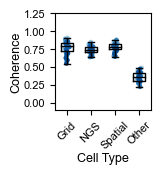

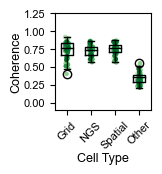

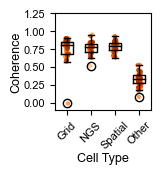

In [164]:
''' Boxplots of Cell Type Coherence, within each Age Group'''

#Young Coherence
fig, ax = plt.subplots(figsize = (1.25,1.25))
coherence = [sgridc[y_sindgrid],sNGSc[y_sind],sspatialc[y_sind],sotherc[y_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(coherence, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=8, rotation = 45)
ax.set_ylabel('Coherence', fontsize=9, labelpad=1)
ax.set_ylim([-0.1,1.25])
ax.set_yticks([0,0.25,0.5,0.75,1,1.25])
ax.tick_params(labelsize = 8)

for i in range(len(coherence)):
    y = coherence[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[0], edgecolors = col_sessiongrid[0], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[0], edgecolors = col_session[0], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5B_1.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5B_1.svg', dpi=400, bbox_inches='tight')
plt.show()

#MA Coherence
fig, ax = plt.subplots(figsize = (1.25,1.25))
coherence = [sgridc[ma_sindgrid],sNGSc[ma_sind],sspatialc[ma_sind],sotherc[ma_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(coherence, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=8, rotation = 45)
ax.set_ylabel('Coherence', fontsize=9, labelpad=1)
ax.set_ylim([-0.1,1.25])
ax.set_yticks([0,0.25,0.5,0.75,1,1.25])
ax.tick_params(labelsize = 8)

for i in range(len(coherence)):
    y = coherence[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[1], edgecolors = col_sessiongrid[1], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[1], edgecolors = col_session[1], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5B_2.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5B_2.svg', dpi=400, bbox_inches='tight')
plt.show()

#Aged Coherence
fig, ax = plt.subplots(figsize = (1.25,1.25))
coherence = [sgridc[age_sindgrid],sNGSc[age_sind],sspatialc[age_sind],sotherc[age_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(coherence, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=8, rotation = 45)
ax.set_ylabel('Coherence', fontsize=9, labelpad=1)
ax.set_ylim([-0.1,1.25])
ax.set_yticks([0,0.25,0.5,0.75,1.0,1.25])
ax.tick_params(labelsize = 8)

for i in range(len(coherence)):
    y = coherence[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[2], edgecolors = col_sessiongrid[2], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[2], edgecolors = col_session[2], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5B_3.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5B_3.svg', dpi=400, bbox_inches='tight')
plt.show()

In [127]:
''' Statistics on Coherence within Age Group, across Cell Types by Session'''

print('Young Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridc[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridc[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSc[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSc[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatialc[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatialc[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherc[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherc[y_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridc[y_sindgrid],sNGSc[y_sind],sspatialc[y_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSc[y_sind],sgridc[y_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatialc[y_sind],sgridc[y_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sotherc[y_sind],sgridc[y_sindgrid])
print('other vs. grid, p = ' + str(p_diff))   
      
print('\nMA Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridc[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridc[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSc[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSc[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatialc[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatialc[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherc[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherc[ma_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridc[ma_sindgrid],sNGSc[ma_sind],sspatialc[ma_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSc[ma_sind],sgridc[ma_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatialc[ma_sind],sgridc[ma_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sotherc[ma_sind],sgridc[ma_sindgrid])
print('other vs. grid, p = ' + str(p_diff)) 
      
print('\nAged Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridc[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridc[age_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSc[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSc[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatialc[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatialc[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherc[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherc[age_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridc[age_sindgrid],sNGSc[age_sind],sspatialc[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSc[age_sind],sgridc[age_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatialc[age_sind],sgridc[age_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sotherc[age_sind],sgridc[age_sindgrid])
print('other vs. grid, p = ' + str(p_diff))  

Young Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7743 ± 0.0123 ; 0.7428 ± 0.0071 ; 0.7768 ± 0.0077 ; 0.3571 ± 0.009
H = 11.688081790746423
p = 0.0028971120141539895
NGS vs. grid, p = 0.006350914689752734
spatial vs. grid, p = 0.5455858675140788
other vs. grid, p = 4.822253156499854e-19

MA Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7383 ± 0.0153 ; 0.731 ± 0.0103 ; 0.7512 ± 0.0102 ; 0.3488 ± 0.0093
H = 2.119846469096431
p = 0.3464824071877076
NGS vs. grid, p = 0.280315206285665
spatial vs. grid, p = 0.9598477999057998
other vs. grid, p = 5.330102030873478e-20

Aged Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7633 ± 0.0198 ; 0.7611 ± 0.0108 ; 0.7842 ± 0.0099 ; 0.3315 ± 0.0119
H = 3.177505033233414
p = 0.20418016428830893
NGS vs. grid, p = 0.1676890382093773
spatial vs. grid, p = 0.9632374463676259
other vs. grid, p = 6.749357312915267e-18


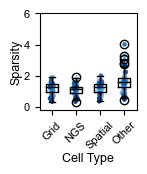

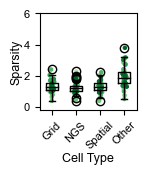

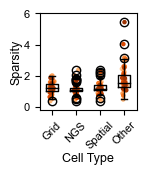

In [155]:
''' Boxplots of Cell Type Sparsity, within each Age Group'''

#Young Sparsity
fig, ax = plt.subplots(figsize = (1.25,1.25))
Sparsity = [sgrids[y_sindgrid],sNGSs[y_sind],sspatials[y_sind],sothers[y_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Sparsity, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Sparsity', fontsize=9, labelpad=1)
ax.set_ylim([-0.2,6])
ax.set_yticks([0,2,4,6])
ax.tick_params(labelsize = 8)

for i in range(len(Sparsity)):
    y = Sparsity[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[0], edgecolors = col_sessiongrid[0], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[0], edgecolors = col_session[0], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5C_1.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5C_1.svg', dpi=400, bbox_inches='tight')
plt.show()

#MA Sparsity
fig, ax = plt.subplots(figsize = (1.25,1.25))
Sparsity = [sgrids[ma_sindgrid],sNGSs[ma_sind],sspatials[ma_sind],sothers[ma_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Sparsity, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Sparsity', fontsize=9, labelpad=1)
ax.set_ylim([-0.2,6])
ax.set_yticks([0,2,4,6])
ax.tick_params(labelsize = 8)

for i in range(len(Sparsity)):
    y = Sparsity[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[1], edgecolors = col_sessiongrid[1], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[1], edgecolors = col_session[1], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5C_2.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5C_2.svg', dpi=400, bbox_inches='tight')
plt.show()

#Aged Sparsity
fig, ax = plt.subplots(figsize = (1.25,1.25))
Sparsity = [sgrids[age_sindgrid],sNGSs[age_sind],sspatials[age_sind],sothers[age_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Sparsity, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Sparsity', fontsize=9, labelpad=1)
ax.set_ylim([-0.2,6])
ax.set_yticks([0,2,4,6])
ax.tick_params(labelsize = 8)

for i in range(len(Sparsity)):
    y = Sparsity[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[2], edgecolors = col_sessiongrid[2], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[2], edgecolors = col_session[2], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5C_3.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5C_3.svg', dpi=400, bbox_inches='tight')
plt.show()

In [134]:
''' Statistics on Sparsity within Age Group, across Cell Types by Session'''

print('Young Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgrids[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgrids[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSs[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSs[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatials[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatials[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sothers[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sothers[y_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgrids[y_sindgrid],sNGSs[y_sind],sspatials[y_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSs[y_sind],sgrids[y_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatials[y_sind],sgrids[y_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sothers[y_sind],sgrids[y_sindgrid])
print('other vs. grid, p = ' + str(p_diff))   
      
print('\nMA Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgrids[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgrids[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSs[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSs[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatials[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatials[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sothers[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sothers[ma_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgrids[ma_sindgrid],sNGSs[ma_sind],sspatials[ma_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSs[ma_sind],sgrids[ma_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatials[ma_sind],sgrids[ma_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sothers[ma_sind],sgrids[ma_sindgrid])
print('other vs. grid, p = ' + str(p_diff)) 
      
print('\nAged Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgrids[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgrids[age_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSs[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSs[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatials[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatials[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sothers[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sothers[age_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgrids[age_sindgrid],sNGSs[age_sind],sspatials[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSs[age_sind],sgrids[age_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatials[age_sind],sgrids[age_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sothers[age_sind],sgrids[age_sindgrid])
print('other vs. grid, p = ' + str(p_diff))  

Young Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.1891 ± 0.0551 ; 1.0808 ± 0.046 ; 1.2135 ± 0.0502 ; 1.6464 ± 0.0937
H = 5.664875830251162
p = 0.05886916056784547
NGS vs. grid, p = 0.09870540750626126
spatial vs. grid, p = 0.6537074463661512
other vs. grid, p = 5.84786414656039e-05

MA Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.3264 ± 0.0487 ; 1.1967 ± 0.0436 ; 1.3138 ± 0.0469 ; 1.9246 ± 0.0824
H = 6.3856041146279985
p = 0.04105666647710207
NGS vs. grid, p = 0.03306823538940019
spatial vs. grid, p = 0.8711314915971583
other vs. grid, p = 1.197195345795314e-08

Aged Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.2233 ± 0.0478 ; 1.1275 ± 0.0478 ; 1.2404 ± 0.052 ; 1.7559 ± 0.1119
H = 5.998172736762782
p = 0.04983257619325122
NGS vs. grid, p = 0.039813961715343536
spatial vs. grid, p = 0.8754729607164109
other vs. grid, p = 1.9182149810963077e-05


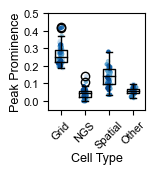

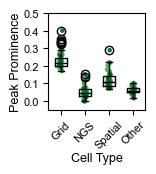

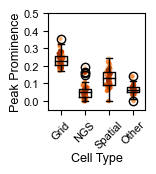

In [156]:
''' Boxplots of Cell Type Distance, within each Age Group'''

#Young Distance
fig, ax = plt.subplots(figsize = (1.25,1.25))
Distance = [sgridd[y_sindgrid],sNGSd[y_sind],sspatiald[y_sind],sotherd[y_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Distance, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Peak Prominence', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 8)

for i in range(len(Distance)):
    y = Distance[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[0], edgecolors = col_sessiongrid[0], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[0], edgecolors = col_session[0], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5D_1.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5D_1.svg', dpi=400, bbox_inches='tight')
plt.show()

#MA Distance
fig, ax = plt.subplots(figsize = (1.25,1.25))
Distance = [sgridd[ma_sindgrid],sNGSd[ma_sind],sspatiald[ma_sind],sotherd[ma_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Distance, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Peak Prominence', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 8)

for i in range(len(Distance)):
    y = Distance[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[1], edgecolors = col_sessiongrid[1], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[1], edgecolors = col_session[1], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5D_2.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5D_2.svg', dpi=400, bbox_inches='tight')
plt.show()

#Aged Distance
fig, ax = plt.subplots(figsize = (1.25,1.25))
Distance = [sgridd[age_sindgrid],sNGSd[age_sind],sspatiald[age_sind],sotherd[age_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Distance, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Peak Prominence', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 8)

for i in range(len(Distance)):
    y = Distance[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[2], edgecolors = col_sessiongrid[2], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[2], edgecolors = col_session[2], alpha = 1, s = 5)

fig.savefig(save_folder + 'Reviewer5D_3.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'Reviewer5D_3.svg', dpi=400, bbox_inches='tight')
plt.show()

In [141]:
''' Statistics on Distance Tuning within Age Group, across Cell Types by Session'''

print('Young Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridd[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridd[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSd[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSd[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatiald[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatiald[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherd[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherd[y_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridd[y_sindgrid],sNGSd[y_sind],sspatiald[y_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSd[y_sind],sgridd[y_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatiald[y_sind],sgridd[y_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sotherd[y_sind],sgridd[y_sindgrid])
print('other vs. grid, p = ' + str(p_diff))   
      
print('\nMA Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridd[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridd[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSd[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSd[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatiald[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatiald[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherd[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherd[ma_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridd[ma_sindgrid],sNGSd[ma_sind],sspatiald[ma_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSd[ma_sind],sgridd[ma_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatiald[ma_sind],sgridd[ma_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sotherd[ma_sind],sgridd[ma_sindgrid])
print('other vs. grid, p = ' + str(p_diff)) 
      
print('\nAged Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridd[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridd[age_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSd[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSd[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatiald[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatiald[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherd[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherd[age_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridd[age_sindgrid],sNGSd[age_sind],sspatiald[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

stat, p_diff = stats.ranksums(sNGSd[age_sind],sgridd[age_sindgrid])
print('NGS vs. grid, p = ' + str(p_diff))      

stat, p_diff = stats.ranksums(sspatiald[age_sind],sgridd[age_sindgrid])
print('spatial vs. grid, p = ' + str(p_diff))   

stat, p_diff = stats.ranksums(sotherd[age_sind],sgridd[age_sindgrid])
print('other vs. grid, p = ' + str(p_diff))  

Young Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2616 ± 0.0074 ; 0.0407 ± 0.0036 ; 0.1398 ± 0.007 ; 0.0574 ± 0.0023
H = 133.1360266784425
p = 1.229926433712831e-29
NGS vs. grid, p = 4.822253156499854e-19
spatial vs. grid, p = 3.09993854114887e-17
other vs. grid, p = 4.822253156499854e-19

MA Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2322 ± 0.0066 ; 0.0477 ± 0.0044 ; 0.1235 ± 0.0065 ; 0.0607 ± 0.0022
H = 131.9196169932096
p = 2.259535362250074e-29
NGS vs. grid, p = 2.3170160189810767e-20
spatial vs. grid, p = 2.6987870010332957e-15
other vs. grid, p = 2.3170160189810767e-20

Aged Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2338 ± 0.0054 ; 0.0539 ± 0.0057 ; 0.1332 ± 0.0068 ; 0.0657 ± 0.0032
H = 121.25679413887084
p = 4.671127332652958e-27
NGS vs. grid, p = 6.139357198568214e-19
spatial vs. grid, p = 1.2606239804152537e-15
other vs. grid, p = 3.333770426379457e-19


In [144]:
''' Post Hoc Comparisons: Young '''

import statsmodels.api as sm
import scikit_posthocs as ph

# Collect all relevant data into pandas dataframe
CellType = list(np.concatenate((np.full(len(sgridc[y_sindgrid]),str('grid')),np.full(len(sNGSc[y_sind]),str('NGS')),np.full(len(sspatialc[y_sind]),str('spatial')),np.full(len(sotherc[y_sind]),str('other')))))
Coherence = list(np.concatenate((sgridc[y_sindgrid],sNGSc[y_sind],sspatialc[y_sind],sotherc[y_sind])))
Sparsity = list(np.concatenate((sgrids[y_sindgrid],sNGSs[y_sind],sspatials[y_sind],sothers[y_sind])))
Distance = list(np.concatenate((sgridd[y_sindgrid],sNGSd[y_sind],sspatiald[y_sind],sotherd[y_sind])))
            
tuples = list(zip(CellType,Coherence,Sparsity,Distance))
tuples

df = pd.DataFrame(tuples, columns = ['CellType','Coherence','Sparsity','Distance'])

#Run Post Hoc Tests on Coherence, Young
ph.posthoc_conover(df, val_col = 'Coherence', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,1.207614e-03,3.934879e-24,2.241555e-03
grid,1.207614e-03,1.000000e+00,4.035684e-35,7.586336e-01
other,3.934879e-24,4.035684e-35,1.000000e+00,1.896503e-34
spatial,2.241555e-03,7.586336e-01,1.896503e-34,1.000000e+00


In [145]:
#Run Post Hoc Tests on Sparsity, Young
ph.posthoc_conover(df, val_col = 'Sparsity', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,0.172174,3.415474e-08,0.088802
grid,1.721738e-01,1.000000,1.188071e-04,0.649194
other,3.415474e-08,0.000119,1.000000e+00,0.000547
spatial,8.880191e-02,0.649194,5.472970e-04,1.000000


In [146]:
#Run Post Hoc Tests on Distance Tuning, Young
ph.posthoc_conover(df, val_col = 'Distance', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,1.261298e-68,2.601774e-06,9.294353e-39
grid,1.261298e-68,1.000000e+00,2.648620e-55,2.777566e-20
other,2.601774e-06,2.648620e-55,1.000000e+00,1.173417e-23
spatial,9.294353e-39,2.777566e-20,1.173417e-23,1.000000e+00


In [147]:
''' Post Hoc Comparisons: MA '''

# Collect all relevant data into pandas dataframe
CellType = list(np.concatenate((np.full(len(sgridc[ma_sindgrid]),str('grid')),np.full(len(sNGSc[ma_sind]),str('NGS')),np.full(len(sspatialc[ma_sind]),str('spatial')),np.full(len(sotherc[ma_sind]),str('other')))))
Coherence = list(np.concatenate((sgridc[ma_sindgrid],sNGSc[ma_sind],sspatialc[ma_sind],sotherc[ma_sind])))
Sparsity = list(np.concatenate((sgrids[ma_sindgrid],sNGSs[ma_sind],sspatials[ma_sind],sothers[ma_sind])))
Distance = list(np.concatenate((sgridd[ma_sindgrid],sNGSd[ma_sind],sspatiald[ma_sind],sotherd[ma_sind])))
            
tuples = list(zip(CellType,Coherence,Sparsity,Distance))
tuples

df = pd.DataFrame(tuples, columns = ['CellType','Coherence','Sparsity','Distance'])

#Run Post Hoc Tests on Coherence, MA
ph.posthoc_conover(df, val_col = 'Coherence', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,4.037986e-01,8.093886e-29,4.037986e-01
grid,4.037986e-01,1.000000e+00,8.935363e-33,8.422554e-01
other,8.093886e-29,8.935363e-33,1.000000e+00,1.471503e-33
spatial,4.037986e-01,8.422554e-01,1.471503e-33,1.000000e+00


In [148]:
#Run Post Hoc Tests on Sparsity, MA
ph.posthoc_conover(df, val_col = 'Sparsity', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,7.742643e-02,9.038266e-15,7.742643e-02
grid,7.742643e-02,1.000000e+00,6.153040e-09,9.236451e-01
other,9.038266e-15,6.153040e-09,1.000000e+00,3.878109e-09
spatial,7.742643e-02,9.236451e-01,3.878109e-09,1.000000e+00


In [149]:
#Run Post Hoc Tests on Distance, MA
ph.posthoc_conover(df, val_col = 'Distance', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,4.335665e-63,9.690143e-04,1.699989e-34
grid,4.335665e-63,1.000000e+00,4.912473e-53,6.147376e-17
other,9.690143e-04,4.912473e-53,1.000000e+00,9.300833e-24
spatial,1.699989e-34,6.147376e-17,9.300833e-24,1.000000e+00


In [150]:
''' Post Hoc Comparisons: Aged '''

# Collect all relevant data into pandas dataframe
CellType = list(np.concatenate((np.full(len(sgridc[age_sindgrid]),str('grid')),np.full(len(sNGSc[age_sind]),str('NGS')),np.full(len(sspatialc[y_sind]),str('spatial')),np.full(len(sotherc[age_sind]),str('other')))))
Coherence = list(np.concatenate((sgridc[age_sindgrid],sNGSc[age_sind],sspatialc[age_sind],sotherc[age_sind])))
Sparsity = list(np.concatenate((sgrids[age_sindgrid],sNGSs[age_sind],sspatials[age_sind],sothers[age_sind])))
Distance = list(np.concatenate((sgridd[age_sindgrid],sNGSd[age_sind],sspatiald[age_sind],sotherd[age_sind])))
            
tuples = list(zip(CellType,Coherence,Sparsity,Distance))
tuples

df = pd.DataFrame(tuples, columns = ['CellType','Coherence','Sparsity','Distance'])

#Run Post Hoc Tests on Coherence, Aged
ph.posthoc_conover(df, val_col = 'Coherence', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,3.353262e-01,1.911447e-23,3.353262e-01
grid,3.353262e-01,1.000000e+00,9.676470e-28,9.349145e-01
other,1.911447e-23,9.676470e-28,1.000000e+00,4.075623e-28
spatial,3.353262e-01,9.349145e-01,4.075623e-28,1.000000e+00


In [151]:
#Run Post Hoc Tests on Sparsity, Aged
ph.posthoc_conover(df, val_col = 'Sparsity', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,0.105026,1.657429e-09,0.119118
grid,1.050265e-01,1.000000,5.692671e-05,0.814016
other,1.657429e-09,0.000057,1.000000e+00,0.000023
spatial,1.191178e-01,0.814016,2.310496e-05,1.000000


In [152]:
#Run Post Hoc Tests on Distance, Aged
ph.posthoc_conover(df, val_col = 'Distance', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,7.662519e-53,8.215278e-03,8.442877e-25
grid,7.662519e-53,1.000000e+00,7.006450e-45,1.865662e-16
other,8.215278e-03,7.006450e-45,1.000000e+00,7.050003e-17
spatial,8.442877e-25,1.865662e-16,7.050003e-17,1.000000e+00


# Spatial Cell Stability, Context-Matched Similarity, & Similarity Ratio

Mimics Revised Manuscript Figure 2F-I

In [165]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for Spatial Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ grid cell number).

'''

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/crosstrial/sorted/spatial/' # adjust path

for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            #print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            alltrial = np.arange(0, 220, 1)
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        #sort trial labels to correspond
        posxcopy = posx.copy()
        leftsort = left.copy()
        alt_idx = 140
        lefttail = left[alt_idx:]
        lefttail = 1 - lefttail
        leftsort[alt_idx:] = lefttail[np.argsort(lefttail, kind = 'stable')]

        #revise skippedtrials locations
        allcopy = alltrial.copy()
        alltail = alltrial[alt_idx:]
        allcopy[alt_idx:] = alltail[np.argsort(lefttail, kind = 'stable')]
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #sort position & spike train, all copy is in the sorted order
        posxcopy = []
        allcopy = np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])

            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #adjust trialfil so that sorted trials are skipped instead
        count = 0
        if len(skippedtrials) > 0 :
            skippedrawtrialfil = rawtrialfil.copy()
            consec = count_consec(list(np.sort(newskippedtrials).astype(int)))

            for i, k in enumerate(consec):
                t = np.sort(newskippedtrials)[count] 

                if i == 0: 
                    skippedrawtrialfil[rawtrialfil >= t] = skippedrawtrialfil[rawtrialfil >= t] + k
                else: 
                    skippedrawtrialfil[skippedrawtrialfil >= t] = skippedrawtrialfil[skippedrawtrialfil >= t] + k

                count += k
        else:
            skippedrawtrialfil = trial.copy()
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(spatialcells)))
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim

        # save matrix of cross-trial correlations
        d['allspatialsim'] = allsim
                               
        allspatialsim_file = 'allspatialsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allspatialsim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [187]:
''' Calculate Local Cross Trial Correlation Stability within Each Context'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

#Adjust paths (match load folder to output of cell above)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/simmatrices/'
sim_load_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/crosstrial/sorted/spatial/'

dt = 0.02

slocstab5A = []
slocstab5B = []
slocstab5A_ = []
slocstab5B_ = []
slocstab5block = []
slocstab5alt = []

mlocstab5A = []
mlocstab5B = []
mlocstab5A_ = []
mlocstab5B_ = []
max_k = 5

#cell arrays
ylocstab5A = []
ylocstab5B = []
ylocstab5A_ = []
ylocstab5B_ = []
ylocstab5block = []
ylocstab5alt = []

malocstab5A = []
malocstab5B = []
malocstab5A_ = []
malocstab5B_ = []
malocstab5block = []
malocstab5alt = []

alocstab5A = []
alocstab5B = []
alocstab5A_ = []
alocstab5B_ = []
alocstab5block = []
alocstab5alt = []

blockstability = []

for m, session in zip(mice, sessions):
    
    m_locstab5A = []
    m_locstab5B = []
    m_locstab5A_ = []
    m_locstab5B_ = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]   
        
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx']
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        allspatialsim_file = 'allspatialsim_' + m + '_' + s + '_'+ '.npy'
        d['allspatialsim'] = np.load(sim_load_folder + allspatialsim_file)
        allspatialsim = d['allspatialsim']
        
        local_stabilityA = []
        local_stabilityB = []
        local_stabilityA_ = []
        local_stabilityB_ = []
        local_stabilityblock = [] 
        local_stabilityalt = []
        for i, c in enumerate(spatialcells):
            
            #divide sim by context
            sim = allspatialsim[:,:,i]
            simA = sim[:lengthA,:lengthA]
            simB = sim[lengthA:(lengthA + lengthB),lengthA:(lengthA + lengthB)]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            simA_ = sim[(lengthA + lengthB):(lengthA + lengthB + lengthA_), (lengthA + lengthB):(lengthA + lengthB + lengthA_)]
            simB_ = sim[(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_),(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_)]
            
            # Context A local neighborhood 5 trials
            max_k = 5
            sum_k = np.zeros(simA.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA, offset=k)
            local_stabilityA = np.append(local_stabilityA, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 1

            #Context B
            max_k = 5
            sum_k = np.zeros(simB.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB, offset=k)
            local_stabilityB = np.append(local_stabilityB, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 2

            #Context A_
            max_k = 5
            sum_k = np.zeros(simA_.shape[0])
            
            if simA_.shape[0] <= 2*max_k:
                print(m, s, simA_.shape[0], simB_.shape[0])
                max_k = simA_.shape[0]//2
                max_k = 3
                
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA_, offset=k)
                    
            local_stabilityA_ = np.append(local_stabilityA_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Context B_
            if simB_.shape[0] <= 10:
                print('keeping lower max k for B_...' + str(max_k))
            else: 
                max_k = 5
                
            sum_k = np.zeros(simB_.shape[0])
            
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB_, offset=k)
                    
            local_stabilityB_ = np.append(local_stabilityB_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5A = np.append(slocstab5A, np.nanmean(local_stabilityA))
        m_locstab5A = np.append(m_locstab5A, local_stabilityA)
        slocstab5B = np.append(slocstab5B, np.nanmean(local_stabilityB))
        m_locstab5B = np.append(m_locstab5B, local_stabilityB)
        slocstab5A_ = np.append(slocstab5A_, np.nanmean(local_stabilityA_))
        m_locstab5A_ = np.append(m_locstab5A_, local_stabilityA_)    
        slocstab5B_ = np.append(slocstab5B_, np.nanmean(local_stabilityB_))
        m_locstab5B_ = np.append(m_locstab5B_, local_stabilityB_)
        
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5A = np.append(alocstab5A, local_stabilityA) 
            alocstab5B = np.append(alocstab5B, local_stabilityB) 
            alocstab5A_ = np.append(alocstab5A_, local_stabilityA_) 
            alocstab5B_ = np.append(alocstab5B_, local_stabilityB_) 
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5A = np.append(malocstab5A, local_stabilityA) 
            malocstab5B = np.append(malocstab5B, local_stabilityB) 
            malocstab5A_ = np.append(malocstab5A_, local_stabilityA_) 
            malocstab5B_ = np.append(malocstab5B_, local_stabilityB_) 
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5A = np.append(ylocstab5A, local_stabilityA) 
            ylocstab5B = np.append(ylocstab5B, local_stabilityB) 
            ylocstab5A_ = np.append(ylocstab5A_, local_stabilityA_) 
            ylocstab5B_ = np.append(ylocstab5B_, local_stabilityB_) 
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 
            
    #pool by animal
    mlocstab5A = np.append(mlocstab5A, np.nanmean(m_locstab5A))
    mlocstab5B = np.append(mlocstab5B, np.nanmean(m_locstab5B))
    mlocstab5A_ = np.append(mlocstab5A_, np.nanmean(m_locstab5A_))
    mlocstab5B_ = np.append(mlocstab5B_, np.nanmean(m_locstab5B_))

#save arrays
slocstab5A = np.asarray(slocstab5A)
slocstab5B = np.asarray(slocstab5B)
slocstab5A_ = np.asarray(slocstab5A_)
slocstab5B_ = np.asarray(slocstab5B_)
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

mlocstab5A = np.asarray(mlocstab5A)
mlocstab5B = np.asarray(mlocstab5B)
mlocstab5A_ = np.asarray(mlocstab5A_)
mlocstab5B_ = np.asarray(mlocstab5B_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [188]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Spatial Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

engagement_folder = 'C:/Users/Python/Desktop/LocalData/behaviorsm/engagement' #adjust path

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []
cengageA = []
cengageB = []
cengageA_ = []
cengageB_ = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        engagement_file = 'engagement_' + str(m) + '_' + str(s) + '.npy'
        blocknclickrate = np.load(engagement_folder + engagement_file)
        
        for j, c in enumerate(spatialcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            cengageA = np.append(cengageA, blocknclickrate[0])
            cengageB = np.append(cengageA, blocknclickrate[1])
            cengageA_ = np.append(cengageA, blocknclickrate[2])
            cengageB_ = np.append(cengageA, blocknclickrate[3])
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)
EngageA = list(cengageA)
EngageB = list(cengageB)
EngageA_ = list(cengageA_)
EngageB_ = list(cengageB_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5A
No. Observations:     13464       Method:                 REML     
No. Groups:           29          Scale:                  0.0167   
Min. group size:      96          Log-Likelihood:         2053.7410
Max. group size:      803         Converged:              Yes      
Mean group size:      464.3                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.366    0.027 13.487 0.000  0.313  0.419
C(AgeGroup)[T.2.0]       -0.097    0.040 -2.427 0.015 -0.176 -0.019
C(AgeGroup)[T.3.0]        0.031    0.032  0.957 0.338 -0.032  0.093
C(Sex)[T.M]               0.029    0.042  0.684 0.494 -0.053  0.110
C(Cohort)[T.D]           -0.030    0.052 -0.574 0.566 -0.131  0

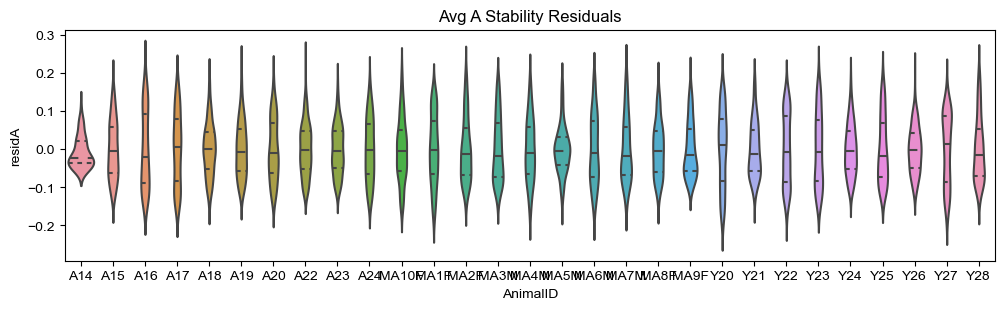

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5B
No. Observations:     13464       Method:                 REML     
No. Groups:           29          Scale:                  0.0163   
Min. group size:      96          Log-Likelihood:         2365.9465
Max. group size:      803         Converged:              Yes      
Mean group size:      464.3                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.315    0.029 10.796 0.000  0.258  0.372
C(AgeGroup)[T.2.0]       -0.046    0.043 -1.058 0.290 -0.131  0.039
C(AgeGroup)[T.3.0]        0.010    0.034  0.280 0.779 -0.058  0.077
C(Sex)[T.M]               0.014    0.045  0.314 0.753 -0.075  0.103
C(Cohort)[T.D]            0.007    0.056  0.120 0.905 -0.103  0

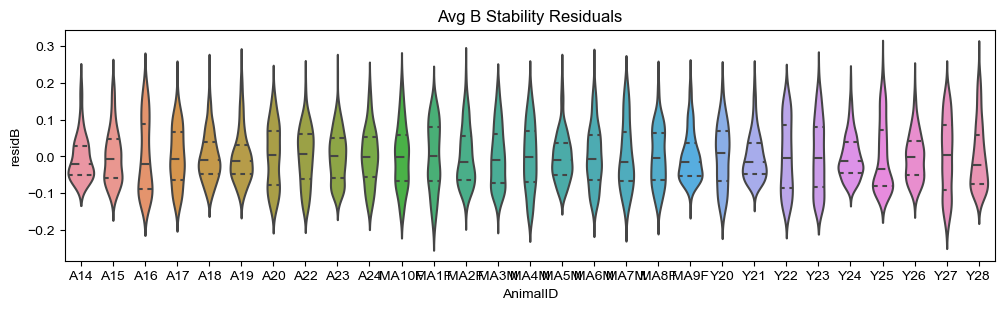

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5A_
No. Observations:      13464      Method:                REML      
No. Groups:            29         Scale:                 0.0107    
Min. group size:       96         Log-Likelihood:        5355.9109 
Max. group size:       803        Converged:             Yes       
Mean group size:       464.3                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.150    0.026  5.860 0.000  0.100  0.200
C(AgeGroup)[T.2.0]       -0.077    0.038 -2.005 0.045 -0.151 -0.002
C(AgeGroup)[T.3.0]        0.062    0.030  2.063 0.039  0.003  0.121
C(Sex)[T.M]               0.032    0.040  0.790 0.430 -0.047  0.110
C(Cohort)[T.D]           -0.027    0.049 -0.542 0.588 -0.124  0

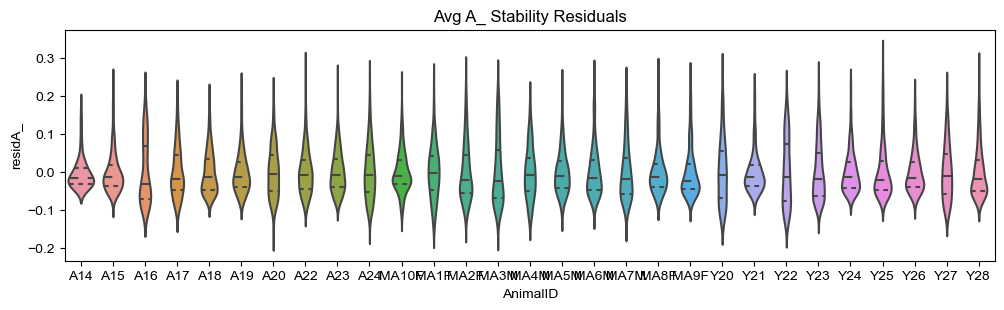

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5B_
No. Observations:      13464      Method:                REML      
No. Groups:            29         Scale:                 0.0101    
Min. group size:       96         Log-Likelihood:        5638.7628 
Max. group size:       803        Converged:             Yes       
Mean group size:       464.3                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.127    0.024  5.318 0.000  0.080  0.174
C(AgeGroup)[T.2.0]       -0.044    0.036 -1.224 0.221 -0.113  0.026
C(AgeGroup)[T.3.0]        0.058    0.028  2.073 0.038  0.003  0.114
C(Sex)[T.M]               0.041    0.037  1.107 0.268 -0.032  0.114
C(Cohort)[T.D]           -0.021    0.046 -0.452 0.651 -0.111  0

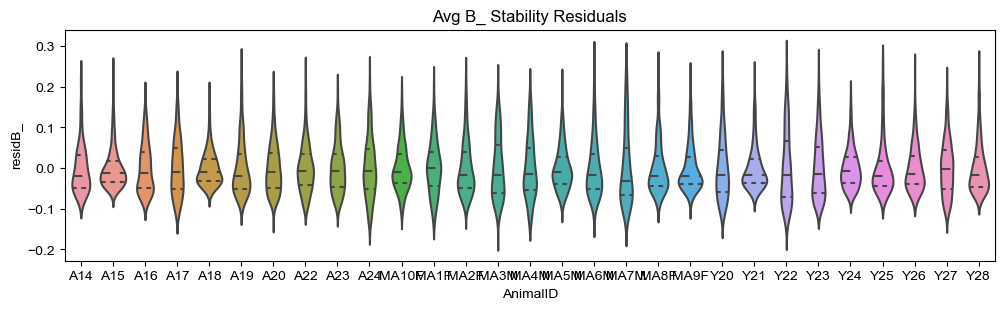

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     13464     Method:               REML         
No. Groups:           29        Scale:                0.0130       
Min. group size:      96        Log-Likelihood:       3949.0664    
Max. group size:      803       Converged:            Yes          
Mean group size:      464.3                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.315    0.026 12.115 0.000  0.264  0.366
C(AgeGroup)[T.2.0]       -0.077    0.039 -1.970 0.049 -0.155 -0.000
C(AgeGroup)[T.3.0]        0.017    0.031  0.539 0.590 -0.044  0.078
C(Sex)[T.M]               0.025    0.041  0.599 0.549 -0.056  0.105
C(Cohort)[T.D]           -0.020    0.051 -0.388 0.698 -0.119  0

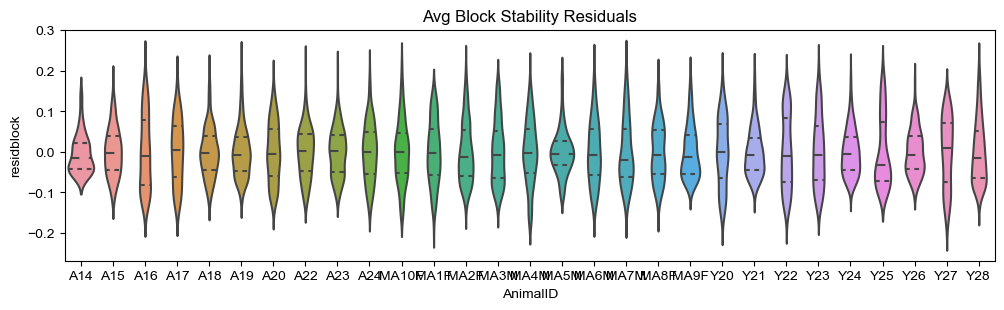

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     13464      Method:                REML       
No. Groups:           29         Scale:                 0.0068     
Min. group size:      96         Log-Likelihood:        8297.4120  
Max. group size:      803        Converged:             Yes        
Mean group size:      464.3                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.142    0.019  7.356 0.000  0.104  0.180
C(AgeGroup)[T.2.0]       -0.055    0.029 -1.876 0.061 -0.112  0.002
C(AgeGroup)[T.3.0]        0.033    0.023  1.449 0.147 -0.012  0.079
C(Sex)[T.M]               0.028    0.031  0.913 0.361 -0.032  0.088
C(Cohort)[T.D]           -0.020    0.038 -0.517 0.605 -0.094  0

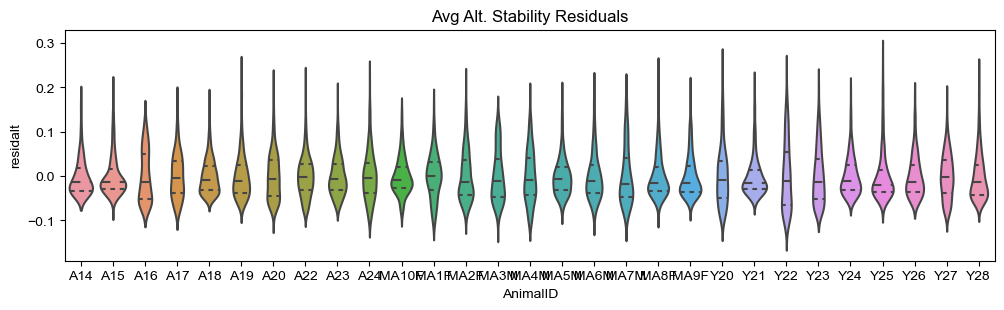

In [189]:
''' LMMs for Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5A = list(np.concatenate((alocstab5A, malocstab5A, ylocstab5A)))
locstab5B = list(np.concatenate((alocstab5B, malocstab5B, ylocstab5B)))
locstab5A_ = list(np.concatenate((alocstab5A_, malocstab5A_, ylocstab5A_)))
locstab5B_ = list(np.concatenate((alocstab5B_, malocstab5B_, ylocstab5B_)))
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, locstab5A, locstab5B, locstab5A_, locstab5B_,locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','locstab5A','locstab5B', 'locstab5A_', 'locstab5B_','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#A Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('locstab5A ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['residA'] = mA.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA', inner = 'quartile', ax = ax)
plt.title('Avg A Stability Residuals')
plt.show()

#B Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('locstab5B ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['residB'] = mB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB', inner = 'quartile', ax = ax)
plt.title('Avg B Stability Residuals')
plt.show()

#A_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_ = smf.mixedlm('locstab5A_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_.summary())
print(mA_.wald_test_terms(scalar = False))

df['residA_'] = mA_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA_', inner = 'quartile', ax = ax)
plt.title('Avg A_ Stability Residuals')
plt.show()

#B_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB_ = smf.mixedlm('locstab5B_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB_.summary())
print(mB_.wald_test_terms(scalar = False))

df['residB_'] = mB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB_', inner = 'quartile', ax = ax)
plt.title('Avg B_ Stability Residuals')
plt.show()

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()


In [190]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


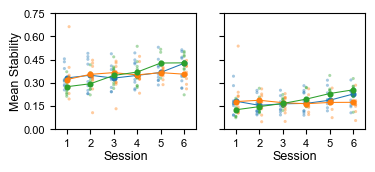

In [192]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Like Figure 2F)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[0].set_ylim([0.0,0.75])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
#ax[1].set_yticks([0,0.15,0.3,0.45,0.6])
#ax[1].set_ylim([0.0,0.6])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure6A.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6A.svg', dpi=400, bbox_inches='tight')
plt.show()

In [193]:
''' Find where I will have NaNs'''
nan_idxspatial = np.where((sperspatial == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindspatial = np.setdiff1d(y_sind, nan_idxspatial)
ma_sindspatial = np.setdiff1d(ma_sind, nan_idxspatial)
age_sindspatial = np.setdiff1d(age_sind, nan_idxspatial)

col_sessionspatial = [col_session_young, col_session_MA, col_session_old] 

# This will fix session stats & box plots are plotted.

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.22434645923859464 0.6856942675182005 0.4011304642371977 0.4377056838743587
P [Young, MA, Aged, All]: 
0.10291328680141316 2.86663516684816e-09 0.0024044890397273084 3.3172307703561824e-09
0.8623408705687187 0.8791666666666667 0.45789859456440807

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.21110167651828665 0.8611431140542987 0.70989188660977 0.6526432487710077
P [Young, MA, Aged, All]: 
0.585599328144345 0.002860151749540076 0.04853001520861869 0.00030185342767943054


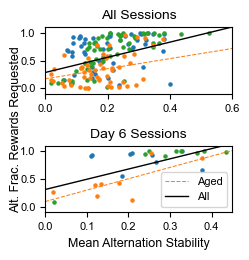

In [194]:
''' Plot Original Manuscript Figure 2G '''
### TOTAL ALT STABILITY vs. REQ RATES
slocstab5alt = np.nanmean(np.vstack((slocstab5A_,slocstab5B_)), axis = 0)

#Linear regression
res = stats.linregress(slocstab5alt[y_sindspatial],reqalt_rates[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindspatial],reqalt_rates[ma_sindspatial])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindspatial],reqalt_rates[age_sindspatial])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5alt[~np.isnan(slocstab5alt)],reqalt_rates[~np.isnan(slocstab5alt)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
        
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)
ax[0].scatter(slocstab5alt[y_sindspatial],reqalt_rates[y_sindspatial], color = 'C0', s = 5)
ax[0].scatter(slocstab5alt[ma_sindspatial],reqalt_rates[ma_sindspatial], color = 'C2', s = 5)
ax[0].scatter(slocstab5alt[age_sindspatial],reqalt_rates[age_sindspatial], color = 'C1', s = 5)
ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0,0.6])
ax[0].set_yticks([0,0.5,1.0])
ax[0].tick_params(labelsize = 8)
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
#plt.savefig(save_folder + 'alldays_stab_correlation.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'alldays_stab_correlation.svg', dpi = 400, bbox_inches = 'tight')

#Select 6th sessions
sixthsesh = []
seshcount = 0
for m, session in zip(mice, sessions):
    totalsesh = len(session)
    for i, s in enumerate(session):
        if (i == (totalsesh - 1)) & (totalsesh >= 6):
            sixthsesh = np.append(sixthsesh, seshcount)
        seshcount += 1

# Get indices for six sesssions in each age group
y_sind6th = np.intersect1d(y_sindspatial, sixthsesh).astype(int)
ma_sind6th = np.intersect1d(ma_sindspatial, sixthsesh).astype(int)
age_sind6th = np.intersect1d(age_sindspatial, sixthsesh).astype(int)
print(np.mean(reqalt_rates[y_sind6th]), np.mean(reqalt_rates[ma_sind6th]), np.mean(reqalt_rates[age_sind6th]))

### TOTAL ALT STABILITY vs. 6th day REQ RATES
slocstab5alt = np.nanmean(np.vstack((slocstab5A_,slocstab5B_)), axis = 0)

#Linear regression
res = stats.linregress(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5alt[age_sind6th],reqalt_rates[age_sind6th])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th,ma_sind6th,age_sind6th))
res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

# Plot Day 6 relationships
ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th], color = 'C0', s = 5)
ax[1].scatter(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th], color = 'C2', s = 5)
ax[1].scatter(slocstab5alt[age_sind6th],reqalt_rates[age_sind6th], color = 'C1', s = 5)
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0,0.45])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All')
ax[1].set_xlabel('Mean Alternation Stability', fontsize = 9)
ax[1].legend(loc = 4, fontsize = 8, prop = {'size': 8})

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
#plt.savefig(save_folder + 'day6_stab_correlation.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'day6_stab_correlation.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.15039672581788743 0.6332123545251225 0.6070208951555482 0.46606333073257256
P [Young, MA, Aged, All]: 
0.2776939251022653 9.607228549839031e-08 8.959156567998438e-07 2.1911955854354886e-10

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.22434645923859464 0.6856942675182005 0.4011304642371977 0.4377056838743586
P [Young, MA, Aged, All]: 
0.10291328680141316 2.86663516684816e-09 0.0024044890397273084 3.3172307703562308e-09

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4231695120685666 0.6974073908031307 0.6664655928695732 0.5874772777513279
P [Young, MA, Aged, All]: 
5.047552631110194e-06 3.4033820275404864e-18 1.9152826210383908e-15 2.2460258187336486e-32

n session halves: young, ma, aged
108 116 110


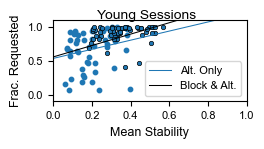

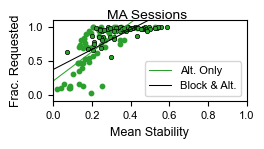

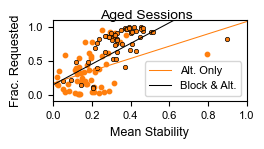

In [198]:
''' Plot Figure 2H with Block & Alt. Data '''
allidx = np.concatenate((y_sindspatial, ma_sindspatial, age_sindspatial))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindspatial],reqblock_rates[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindspatial],reqblock_rates[ma_sindspatial])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindspatial],reqblock_rates[age_sindspatial])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindspatial],reqalt_rates[y_sindspatial])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindspatial],reqalt_rates[ma_sindspatial])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindspatial],reqalt_rates[age_sindspatial])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindspatial],slocstab5alt[y_sindspatial])),np.hstack((reqblock_rates[y_sindspatial],reqalt_rates[y_sindspatial])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindspatial],slocstab5alt[ma_sindspatial])),np.hstack((reqblock_rates[ma_sindspatial],reqalt_rates[ma_sindspatial])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindspatial],slocstab5alt[age_sindspatial])),np.hstack((reqblock_rates[age_sindspatial],reqalt_rates[age_sindspatial])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindspatial)*2,len(ma_sindspatial)*2,len(age_sindspatial)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindspatial],reqalt_rates[y_sindspatial], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindspatial],reqblock_rates[y_sindspatial], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6C_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6C_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindspatial],reqalt_rates[ma_sindspatial], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindspatial],reqblock_rates[ma_sindspatial], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6C_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6C_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindspatial],reqalt_rates[age_sindspatial], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindspatial],reqblock_rates[age_sindspatial], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure6C_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6C_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [199]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindspatial, ma_sindspatial, age_sindspatial))

#Linear regression with block data only
res = stats.spearmanr(slocstab5block[y_sindspatial],reqblock_rates[y_sindspatial])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(slocstab5block[ma_sindspatial],reqblock_rates[ma_sindspatial])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(slocstab5block[age_sindspatial],reqblock_rates[age_sindspatial])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(slocstab5block[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(slocstab5alt[y_sindspatial],reqalt_rates[y_sindspatial])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(slocstab5alt[ma_sindspatial],reqalt_rates[ma_sindspatial])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(slocstab5alt[age_sindspatial],reqalt_rates[age_sindspatial])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(slocstab5alt[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((slocstab5block[y_sindspatial],slocstab5alt[y_sindspatial])),np.hstack((reqblock_rates[y_sindspatial],reqalt_rates[y_sindspatial])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[ma_sindspatial],slocstab5alt[ma_sindspatial])),np.hstack((reqblock_rates[ma_sindspatial],reqalt_rates[ma_sindspatial])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[age_sindspatial],slocstab5alt[age_sindspatial])),np.hstack((reqblock_rates[age_sindspatial],reqalt_rates[age_sindspatial])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3204443330337117 0.6591295396963749 0.6714301534157644 0.5081022594125498
P [Young, MA, Aged, All]: 
0.018159824950680237 1.8484916939499014e-08 2.0140531925735557e-08 2.396752812787323e-12

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2973483134563834 0.7397626681274521 0.3676253139322138 0.4847286191170905
P [Young, MA, Aged, All]: 
0.028993208163751623 3.272565686969397e-11 0.005759395807481517 3.1827531017482467e-11

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5361321692182003 0.7648388007167316 0.7576832145619334 0.6681221858045199
P [Young, MA, Aged, All]: 
2.234289206911998e-09 1.645804658703738e-23 9.66839905774177e-22 1.5374439211625337e-44


In [200]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allspatialsim = d['allspatialsim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(spatialcells):
            sim = allspatialsim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    ABratio   
No. Observations:      13464      Method:                REML      
No. Groups:            29         Scale:                 0.0277    
Min. group size:       96         Log-Likelihood:        -1197.7471
Max. group size:       803        Converged:             Yes       
Mean group size:       464.3                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.159    0.037 31.180 0.000  1.086  1.232
C(AgeGroup)[T.2.0]       -0.048    0.056 -0.845 0.398 -0.158  0.063
C(AgeGroup)[T.3.0]        0.054    0.045  1.217 0.223 -0.033  0.142
C(Sex)[T.M]              -0.033    0.059 -0.564 0.573 -0.148  0.082
C(Cohort)[T.D]            0.059    0.073  0.805 0.421 -0.084  0

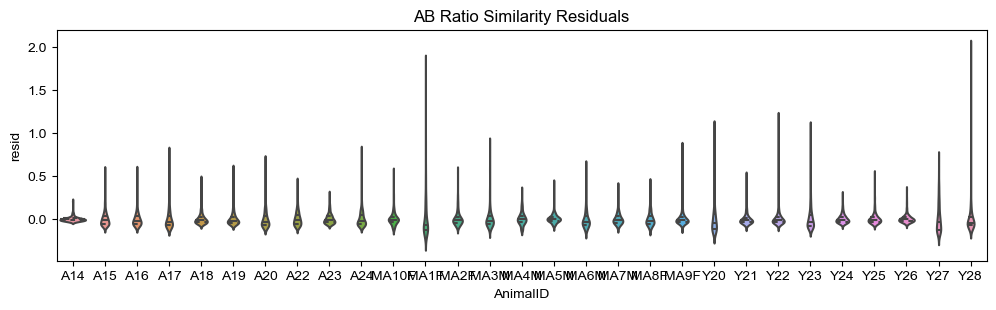

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    A_B_ratio 
No. Observations:      13464      Method:                REML      
No. Groups:            29         Scale:                 0.0030    
Min. group size:       96         Log-Likelihood:        13507.3400
Max. group size:       803        Converged:             Yes       
Mean group size:       464.3                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.024    0.011 95.168 0.000  1.003  1.045
C(AgeGroup)[T.2.0]        0.002    0.016  0.141 0.888 -0.030  0.034
C(AgeGroup)[T.3.0]        0.047    0.013  3.636 0.000  0.022  0.073
C(Sex)[T.M]              -0.009    0.017 -0.517 0.605 -0.042  0.024
C(Cohort)[T.D]            0.017    0.021  0.796 0.426 -0.024  0

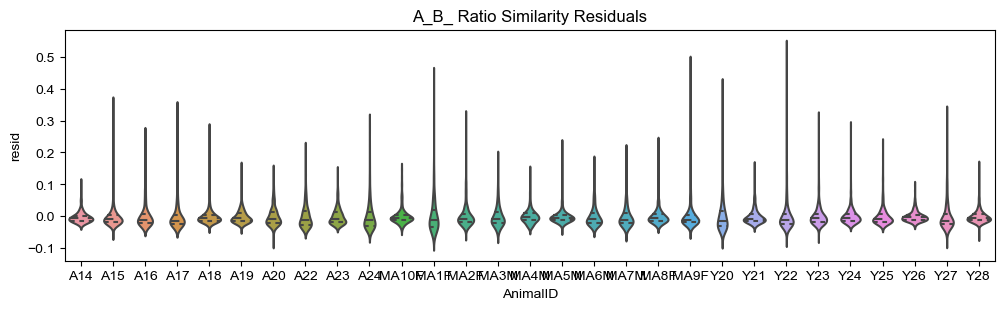

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    AB_ratio  
No. Observations:      13464      Method:                REML      
No. Groups:            29         Scale:                 0.0036    
Min. group size:       96         Log-Likelihood:        12338.8067
Max. group size:       803        Converged:             Yes       
Mean group size:       464.3                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.022    0.012 86.828 0.000  0.999  1.045
C(AgeGroup)[T.2.0]        0.011    0.018  0.619 0.536 -0.024  0.046
C(AgeGroup)[T.3.0]        0.032    0.014  2.265 0.023  0.004  0.060
C(Sex)[T.M]              -0.016    0.018 -0.860 0.390 -0.052  0.020
C(Cohort)[T.D]            0.017    0.023  0.724 0.469 -0.028  0

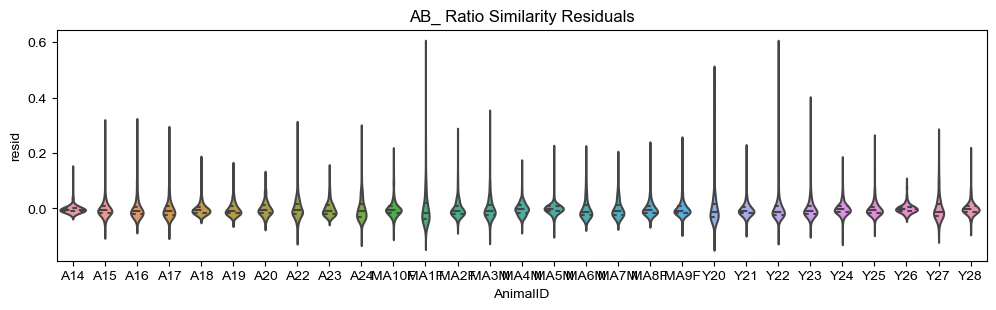

In [201]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [202]:
''' Get fitted session averages '''

df['mAB_fitted'] = mAB_.fittedvalues
resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
#print(resultA_)
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mAB_fitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    
    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
   
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
             
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            


aged, MA, young mice on day 1
10 10 9

aged, MA, young mice on day 2
10 10 9

aged, MA, young mice on day 3
10 10 9

aged, MA, young mice on day 4
9 10 9

aged, MA, young mice on day 5
8 9 9

aged, MA, young mice on day 6
8 9 9


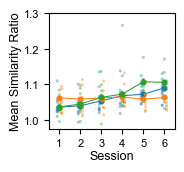

In [203]:
''' Plot Original Manuscript Figure 2j '''
f, ax = plt.subplots(1, 1, figsize=(1.625, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_ylim([0.975,1.3])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    
    print('\naged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    ax.scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

for l in g.lines:
    plt.setp(l,linewidth = 0.75)

#ax.legend(loc = 4, fontsize = 9)
#plt.savefig(save_folder + 'time_altdisc_fitted_composite_LMM.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_altdisc_fitted_composite_LMM.svg', dpi=400, bbox_inches='tight')
plt.show()

In [204]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 9

n aged, MA, young mice on day 1 for alt ratio
10 10 9

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
10 10 9

n aged, MA, young mice on day 3 for alt ratio
10 10 9

n aged, MA, young mice on day 4 for block ratio
9 10 9

n aged, MA, young mice on day 4 for alt ratio
9 10 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
8 9 9

n aged, MA, young mice on day 6 for alt ratio
8 9 9


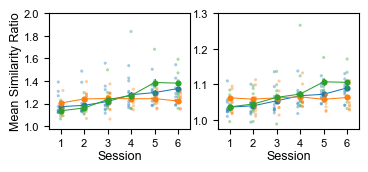

In [206]:
'''Plot Alt. Figure 2G (Mean Similarity Ratio)'''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.2,1.4,1.6,1.8,2])
ax[0].set_ylim([0.975,2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([1,1.1,1.2,1.3])
ax[1].set_ylim([0.975,1.3])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure6B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6B.svg', dpi=400, bbox_inches='tight')
plt.show()

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5498687907326724 0.5509943986569188 0.40285113082825896 0.509194413534093
P [Young, MA, Aged, All]: 
1.6562428291538257e-05 7.3979652631309064e-06 0.0022933654980900574 2.113628962861806e-12

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.037133178756659856 0.6375910388897514 0.7736460868438482 0.6283635519366929
P [Young, MA, Aged, All]: 
0.9244397785968834 0.064705297258674 0.024294422229125135 0.0005871339982193399


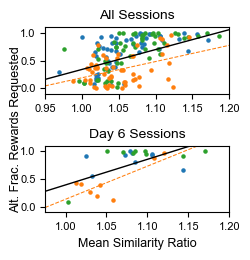

In [181]:
''' Plot Original Figure 2k '''
### A_ vs. REQ ALT RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sindspatial],reqalt_rates[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindspatial],reqalt_rates[ma_sindspatial])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])],reqalt_rates[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
 
#plot all session correlations
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)

ax[0].scatter(sAB_ratio[y_sindspatial],reqalt_rates[y_sindspatial], color = 'C0', label = 'Young', s = 5)
ax[0].scatter(sAB_ratio[ma_sindspatial],reqalt_rates[ma_sindspatial], color = 'C2', label = 'MA', s = 5)
ax[0].scatter(sAB_ratio[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])],reqalt_rates[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])], color = 'C1', s = 5)

ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0.95,1.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_yticks([0,0.5,1.0])
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

#day 6 data
### ALT Stability vs. REQ RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th[~np.isnan(sAB_ratio[y_sind6th])],ma_sind6th[~np.isnan(sAB_ratio[ma_sind6th])],age_sind6th[~np.isnan(sAB_ratio[age_sind6th])]))
res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])], color = 'C0', s = 5)
ax[1].scatter(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])], color = 'C2', s = 5)
ax[1].scatter(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])], color = 'C1', s = 5)
#ax[1].set_xlabel('Avg. Stability in A_ & B_')
#ax[1].set_ylabel('Fraction Rewards Requested')
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0.975,1.2])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].set_xlabel('Mean Similarity Ratio', fontsize = 9)
#ax[1].plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', label = 'Young Fit')
#ax[1].plot(X_plot, maslope1*X_plot + maint1, '--', color = 'C2', label = 'MA Fit')
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
#plt.savefig(save_folder + 'alldays_disc_correlation.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'alldays_disc_correlation.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.34585989082499374 0.4569756326326441 0.6475163049152806 0.4419917805494265
P [Young, MA, Aged, All]: 
0.010417247010117335 0.00031098629411010576 9.148126625526301e-08 2.235003669387512e-09

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5498687907326724 0.5509943986569188 0.40285113082825896 0.509194413534093
P [Young, MA, Aged, All]: 
1.6562428291538257e-05 7.3979652631309064e-06 0.0022933654980900574 2.113628962861806e-12

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5128596708485182 0.4967914464298333 0.7311801700264031 0.5522767270913481
P [Young, MA, Aged, All]: 
1.3887737110045095e-08 1.4106636899167517e-08 1.1973434220558577e-19 4.6180272968805115e-28

n session halves: young, ma, aged
108 116 110


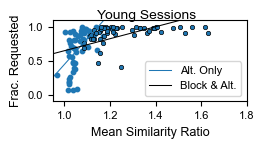

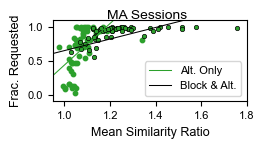

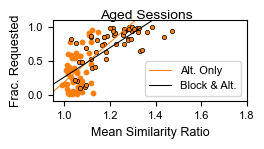

In [207]:
''' Plot Figure 2I '''

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindspatial],reqblock_rates[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindspatial],reqblock_rates[ma_sindspatial])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindspatial],reqblock_rates[age_sindspatial])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[~np.isnan(sABratio)],reqblock_rates[~np.isnan(sABratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindspatial],reqalt_rates[y_sindspatial])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindspatial],reqalt_rates[ma_sindspatial])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindspatial],reqalt_rates[age_sindspatial])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindspatial],sAB_ratio[y_sindspatial])),np.hstack((reqblock_rates[y_sindspatial],reqalt_rates[y_sindspatial])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindspatial],sAB_ratio[ma_sindspatial])),np.hstack((reqblock_rates[ma_sindspatial],reqalt_rates[ma_sindspatial])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindspatial],sAB_ratio[age_sindspatial])),np.hstack((reqblock_rates[age_sindspatial],reqalt_rates[age_sindspatial])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindspatial, ma_sindspatial, age_sindspatial))
res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindspatial)*2,len(ma_sindspatial)*2,len(age_sindspatial)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindspatial],reqalt_rates[y_sindspatial], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindspatial],reqblock_rates[y_sindspatial], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6D_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6D_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindspatial],reqalt_rates[ma_sindspatial], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindspatial],reqblock_rates[ma_sindspatial], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6D_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6D_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindspatial],reqalt_rates[age_sindspatial], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindspatial],reqblock_rates[age_sindspatial], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure6D_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6D_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [208]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindspatial, ma_sindspatial, age_sindspatial))

#Linear regression with block data only
res = stats.spearmanr(sABratio[y_sindspatial],reqblock_rates[y_sindspatial])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(sABratio[ma_sindspatial],reqblock_rates[ma_sindspatial])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(sABratio[age_sindspatial],reqblock_rates[age_sindspatial])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(sABratio[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(sAB_ratio[y_sindspatial],reqalt_rates[y_sindspatial])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(sAB_ratio[ma_sindspatial],reqalt_rates[ma_sindspatial])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(sAB_ratio[age_sindspatial],reqalt_rates[age_sindspatial])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(sAB_ratio[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((sABratio[y_sindspatial],sAB_ratio[y_sindspatial])),np.hstack((reqblock_rates[y_sindspatial],reqalt_rates[y_sindspatial])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[ma_sindspatial],sAB_ratio[ma_sindspatial])),np.hstack((reqblock_rates[ma_sindspatial],reqalt_rates[ma_sindspatial])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[age_sindspatial],sAB_ratio[age_sindspatial])),np.hstack((reqblock_rates[age_sindspatial],reqalt_rates[age_sindspatial])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5284372246598149 0.6745955291772604 0.6689401673582729 0.5898747932333916
P [Young, MA, Aged, All]: 
4.004395211685071e-05 6.392065750650454e-09 2.3729905969521737e-08 4.95546326513793e-17

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.6030463231106061 0.6989626276125497 0.22516509216107322 0.5700809054356665
P [Young, MA, Aged, All]: 
1.3938544208737117e-06 1.0482083157120998e-09 0.09836864677304492 8.8988086076039e-16

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.7080594887138196 0.7045571733252289 0.7386479189594718 0.7151513415333725
P [Young, MA, Aged, All]: 
1.0412134588137748e-17 1.0958351868046103e-18 3.267283906982674e-20 1.3982103230079532e-53


In [209]:
print(save_folder)

C:/Users/Python/Desktop/LocalData/spatialcellssm/simmatrices/
